### Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as ticker
import netCDF4 as nc
import glob
import datetime
from datetime import timedelta
from collections import defaultdict 
from netCDF4 import Dataset as NetCDFFile 
from datetime import datetime, timedelta
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cluster import KMeans, SpectralClustering
from scipy import signal
import xarray as xr
import pylab
import operator
import pickle as pkl
import mpl_toolkits
mpl_toolkits.__path__.append('/home/ninow/packages/basemap-1.1.0/')
from mpl_toolkits.basemap import Basemap

### Define Constants

In [2]:
# paths for data and plots
baseline_experiment_path ='/home/ninow/master_thesis/code/project/results/runs/bias_corrected_baseline/'
observations_path = '/mnt/ds3lab-scratch/ninow/observations/meteoswiss_t2m_20151001-20180331.nc'
time_invariant_grid_data_path = '/mnt/ds3lab-scratch/ninow/topo/topodata.nc'
destination = '/home/ninow/master_thesis/code/project/results/model_results/final_plots'

real_stations = [76, 7, 34, 15, 8, 85, 738, 695, 50, 79, 60, 66, 56, 58, 20, 774, 844, 86, 22, 31, 72, 606, 71, 865, 268, 1024, 67, 81, 95, 13, 14, 521, 92, 59, 867, 205, 93, 182, 84, 952, 139, 94, 317, 748, 29, 65, 915, 51, 273, 18, 33, 3, 409, 847, 414, 468, 861, 294, 731, 64, 711, 43, 666, 47, 359, 152, 53, 850, 38, 39, 69, 46, 28, 862, 26, 97, 143, 842, 27, 87, 78, 45, 9, 37, 48, 77, 2, 863, 75, 301, 630, 83, 88, 10, 17, 843, 44, 61, 70, 23, 52, 856, 36, 35, 54, 57, 25, 762, 1118, 849, 162, 73, 42, 338, 91, 40, 11, 852, 62, 4, 63, 30, 6, 19, 68, 1435, 309, 848, 89, 866, 74, 32, 854, 49, 405, 859, 864, 308, 80, 96, 24, 82, 131, 41]

### Load Data

In [3]:
# 3d distance baseline
error_statistic_per_run_dict_3d = {}
for path in glob.glob(baseline_experiment_path + '/3d_distance/**/experiment_statistic.pkl', recursive=True):
    run = path[-30:-25]
    with open(path, 'rb') as file:
        ds = pkl.load(file)
    error_statistic_per_run_dict_3d[run] = ds

In [4]:
# time invariant observation data
OBS = xr.open_dataset(observations_path)

In [5]:
# load station positions to plot them on map
station_data = pkl.load(open('/mnt/ds3lab-scratch/ninow/preprocessed_data/station/grid_size_1/time_invariant_data_per_station.pkl','rb'))
station_positions = station_data.station_position.sel(positinal_attribute = ['rlat', 'rlon','height_raw'])
stations = station_data.station
station_names = station_data.station_name

station_idx_mapping = {}
for s_idx, s in enumerate(stations.data):
    station_idx_mapping[s] = s_idx

### Prepare data

In [6]:
# get all station ids
stations = OBS.station_id.data

# time invarioant (x,y,z)-coordiantes of stations
station_x, station_y = [],[]
for s in stations:
    OBS_station = OBS.sel(station_id = s)
    station_x += [OBS_station.rlon.item()]
    station_y += [OBS_station.rlat.item()]

## Plot K-Fold Station Cross Validation Results

### Results without dropout

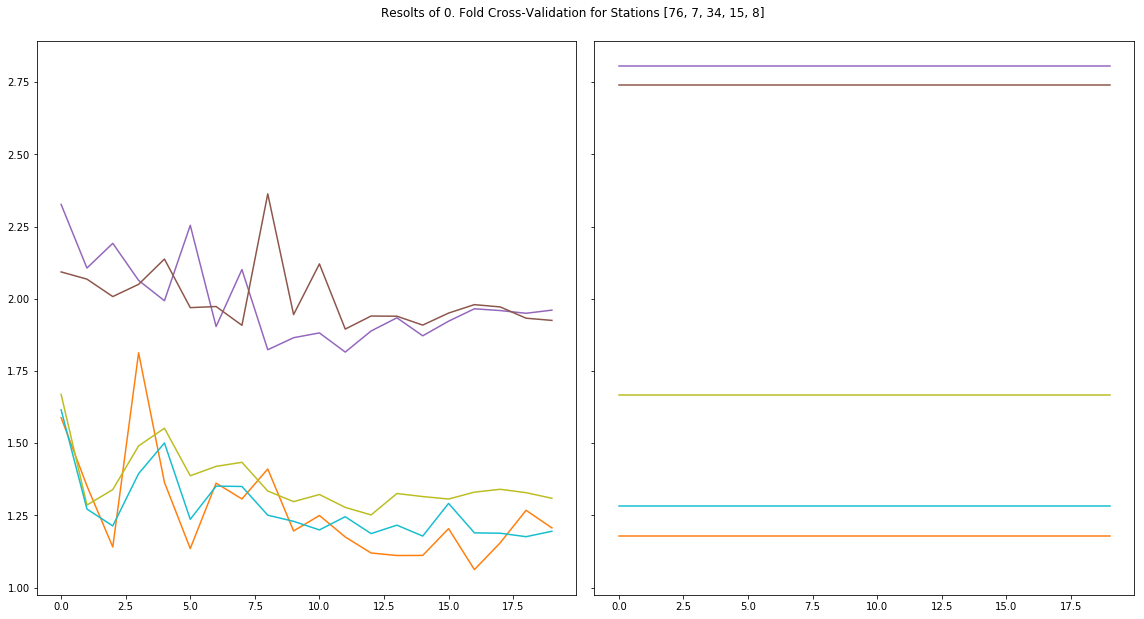

Error


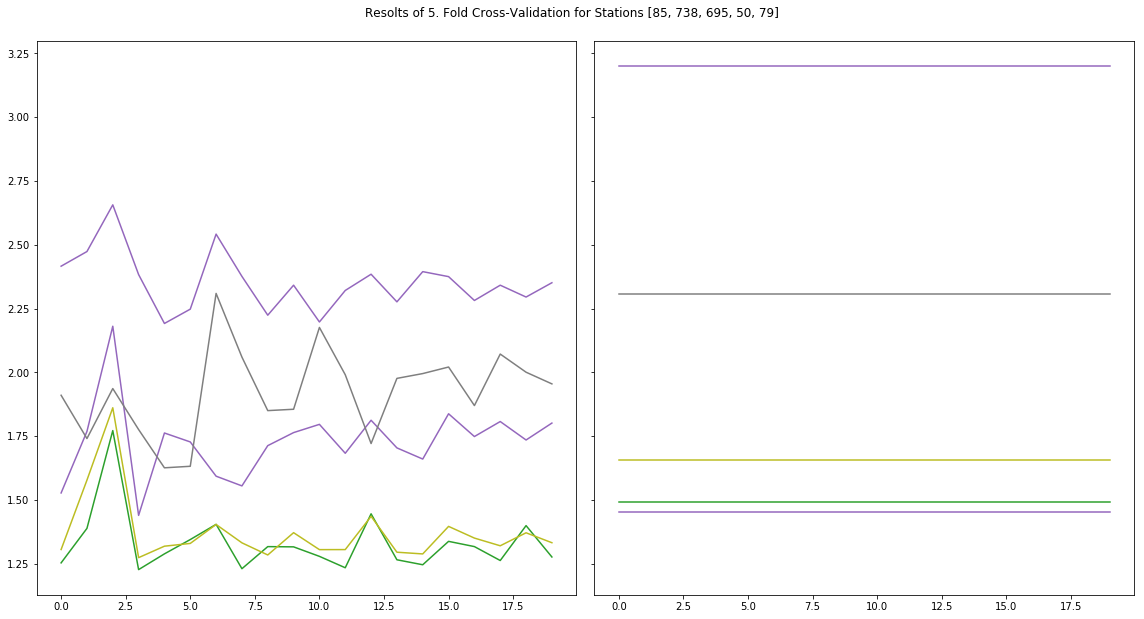

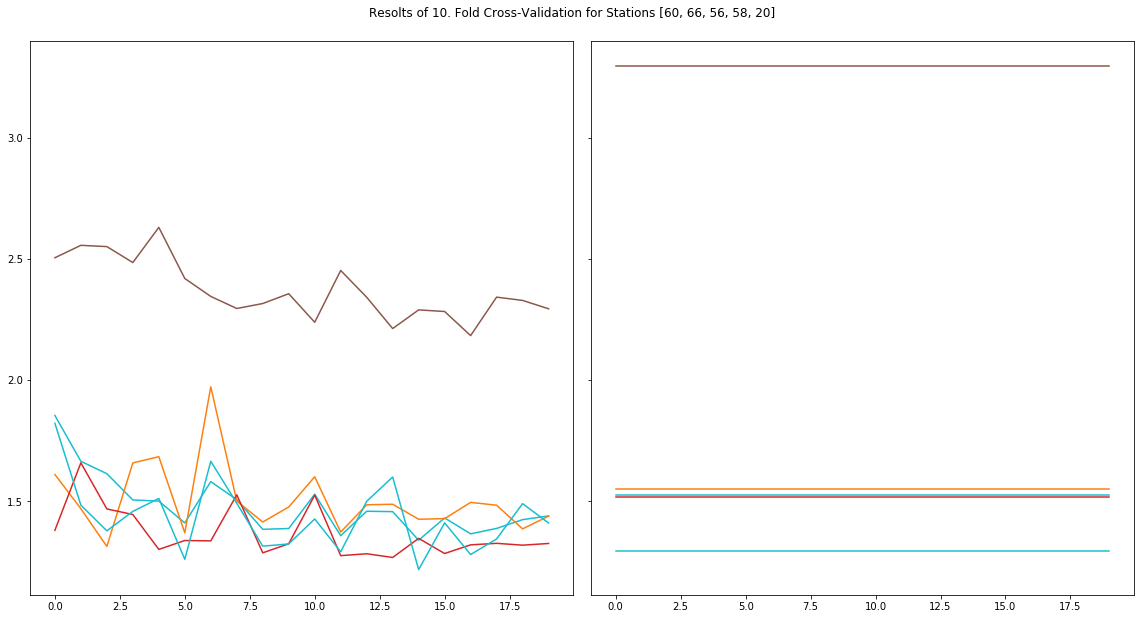

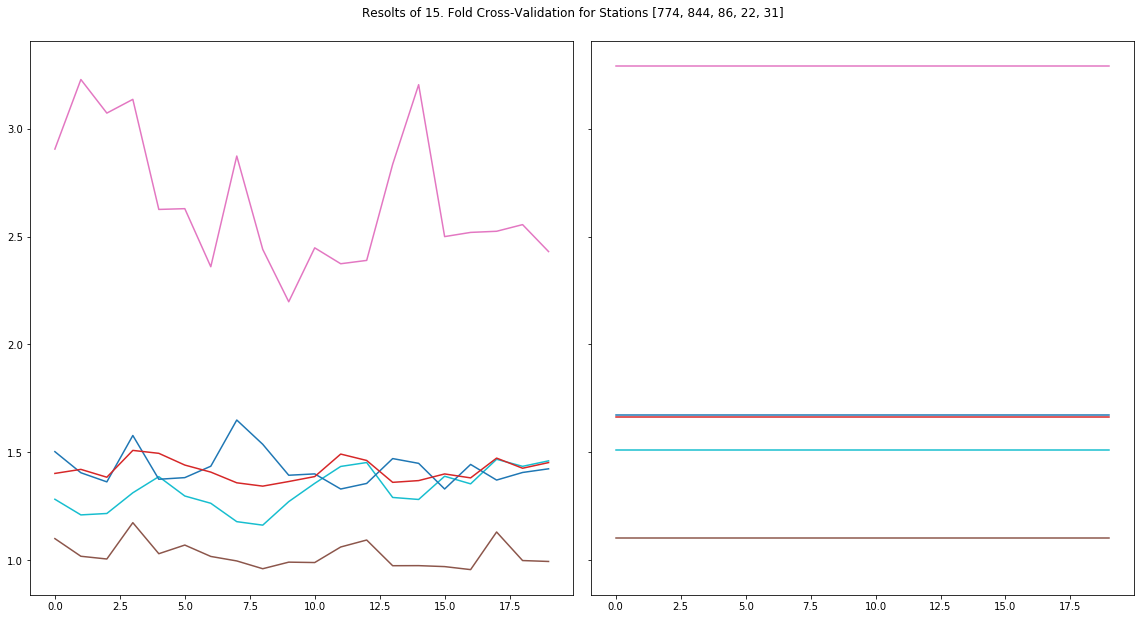

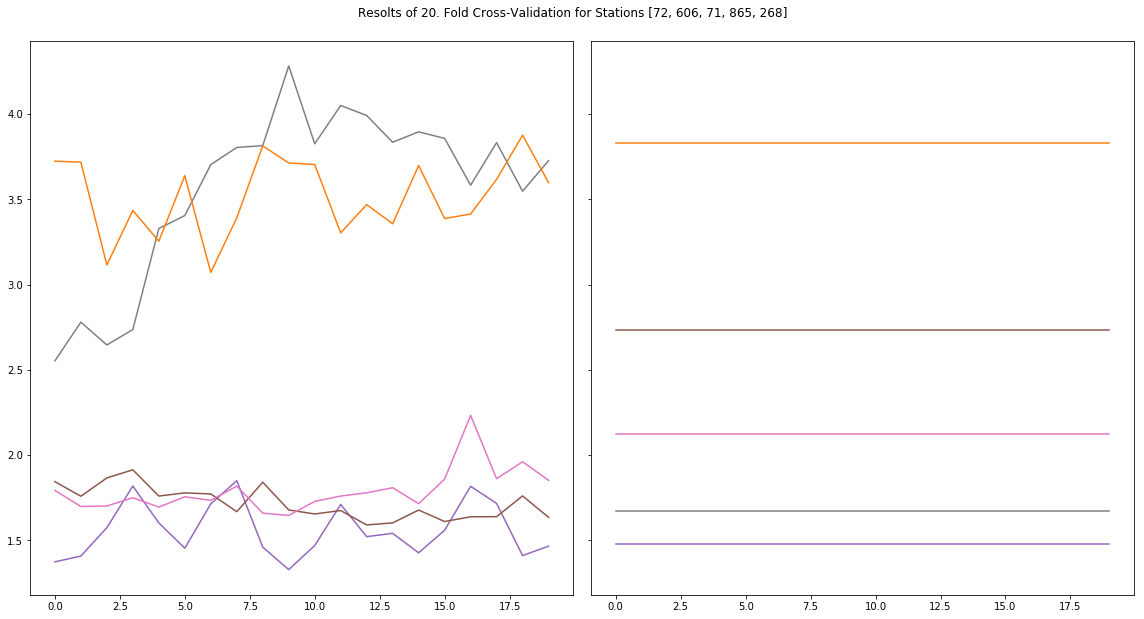

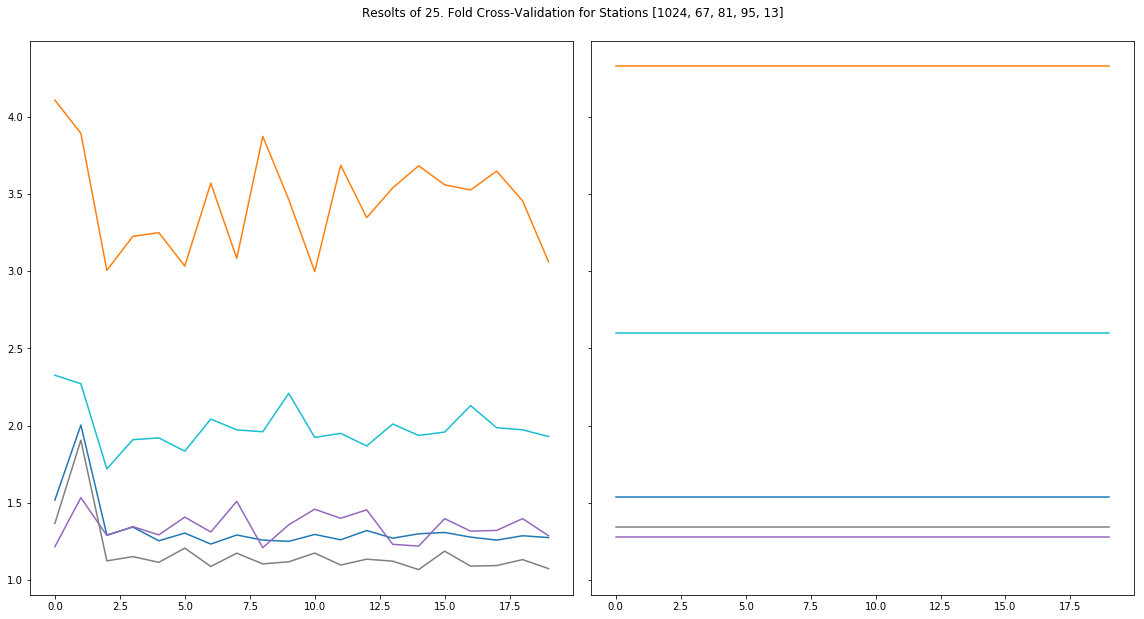

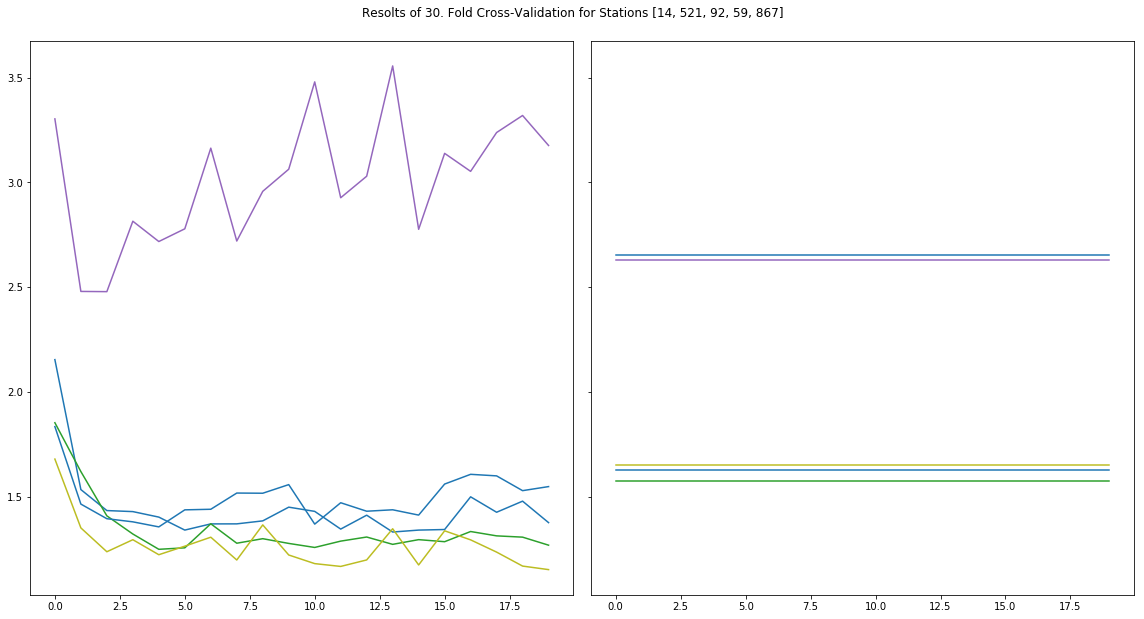

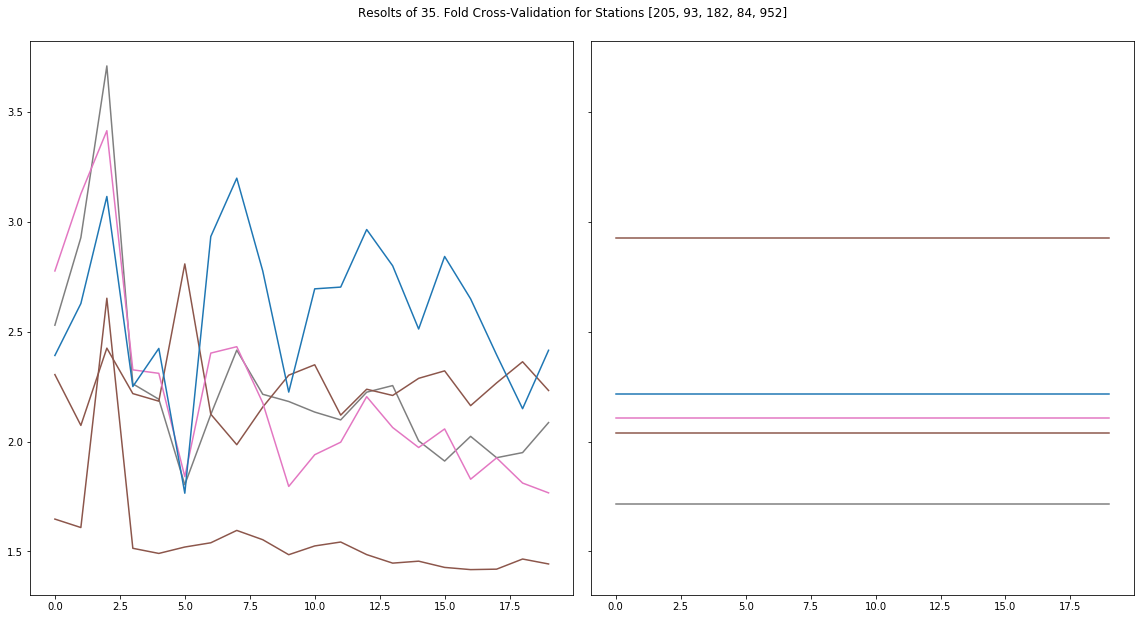

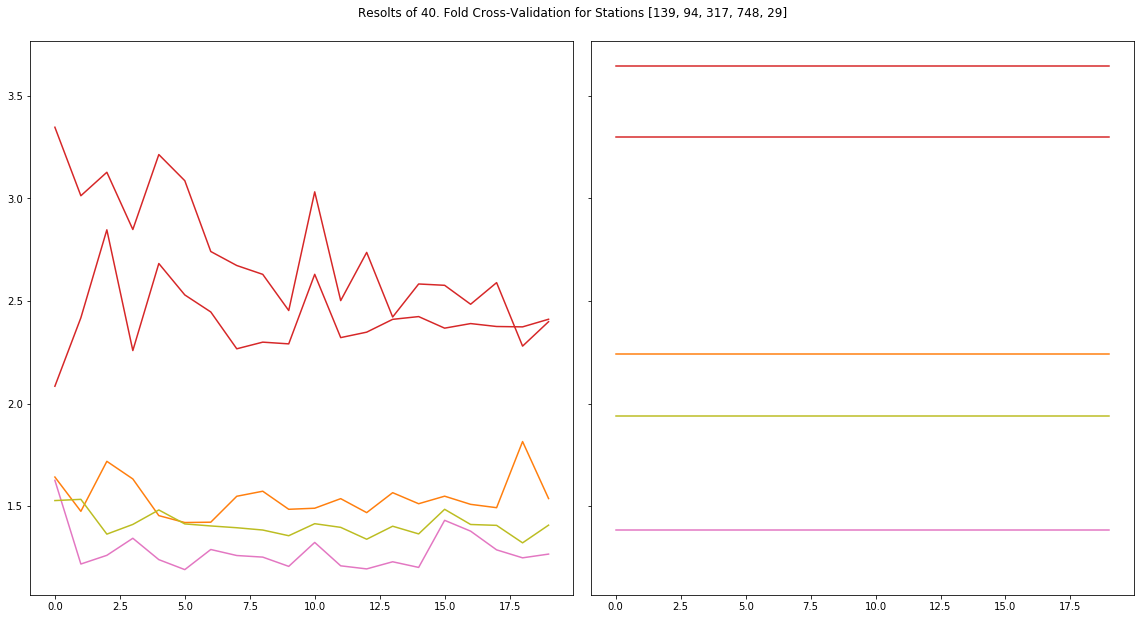

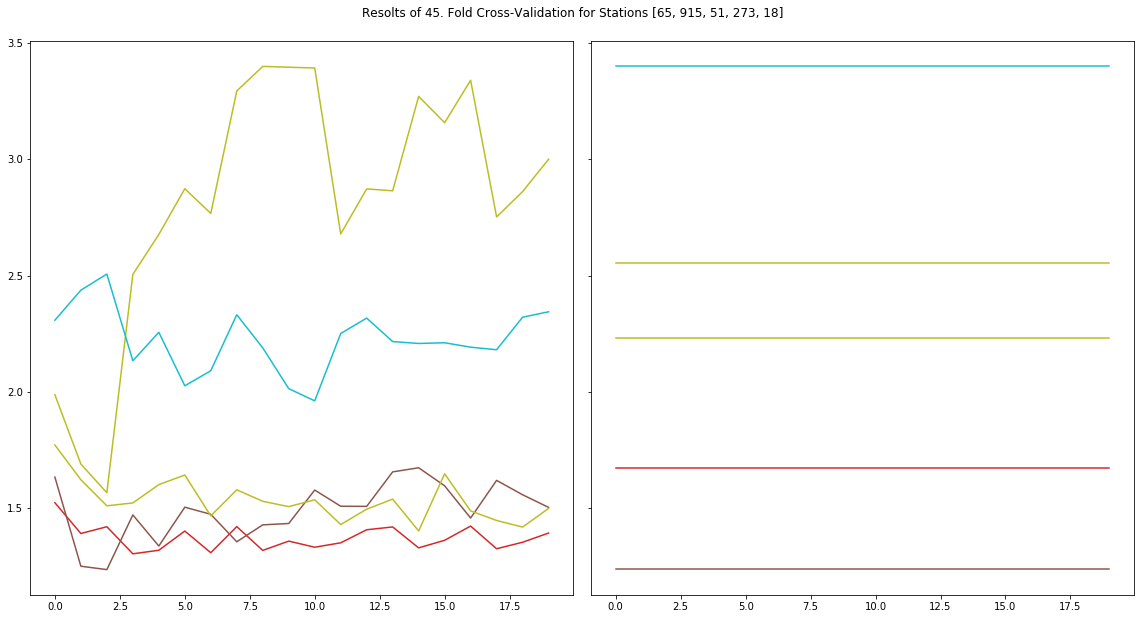

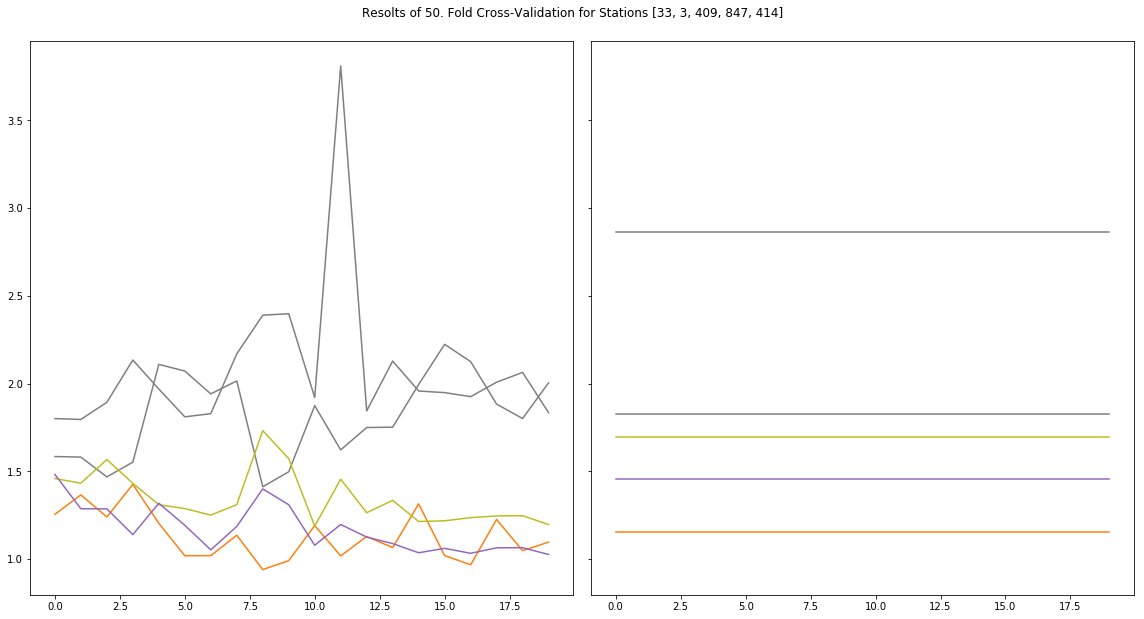

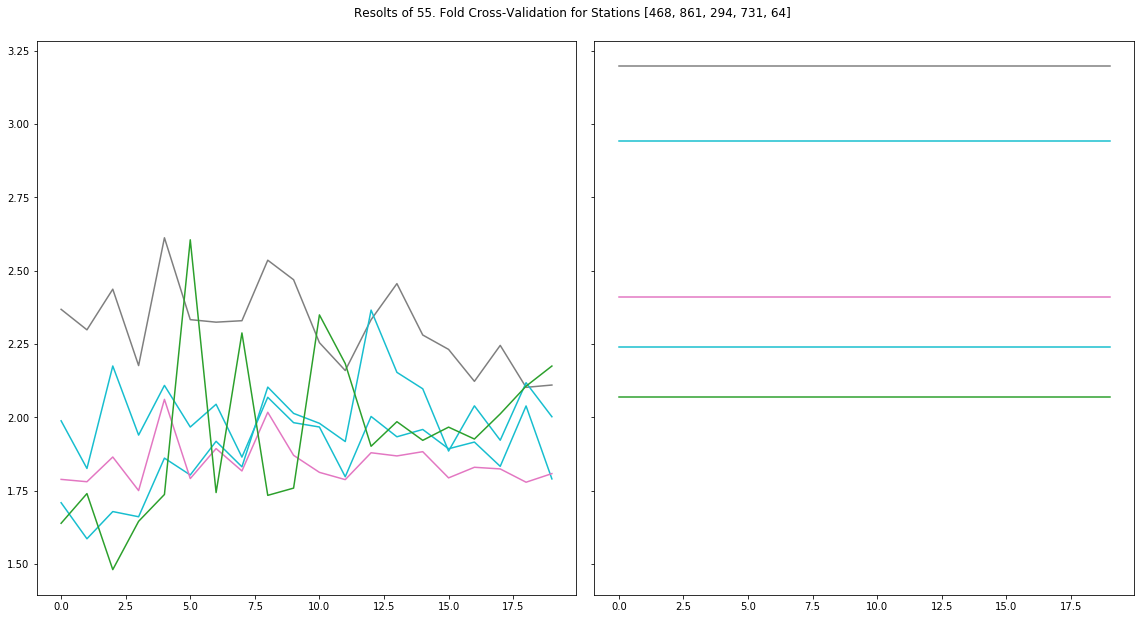

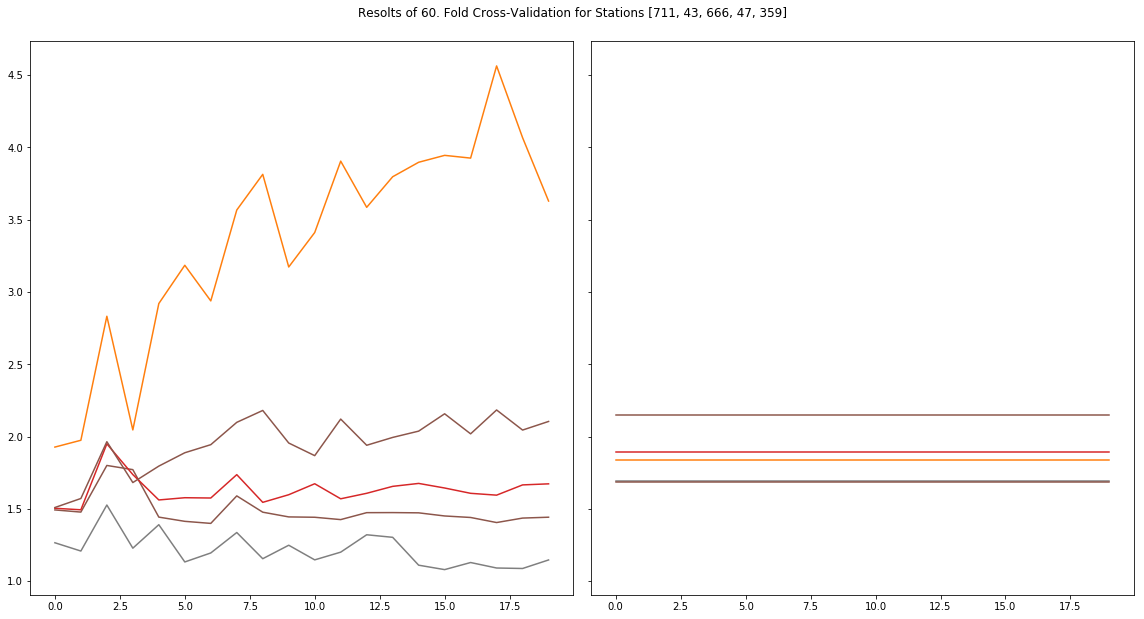

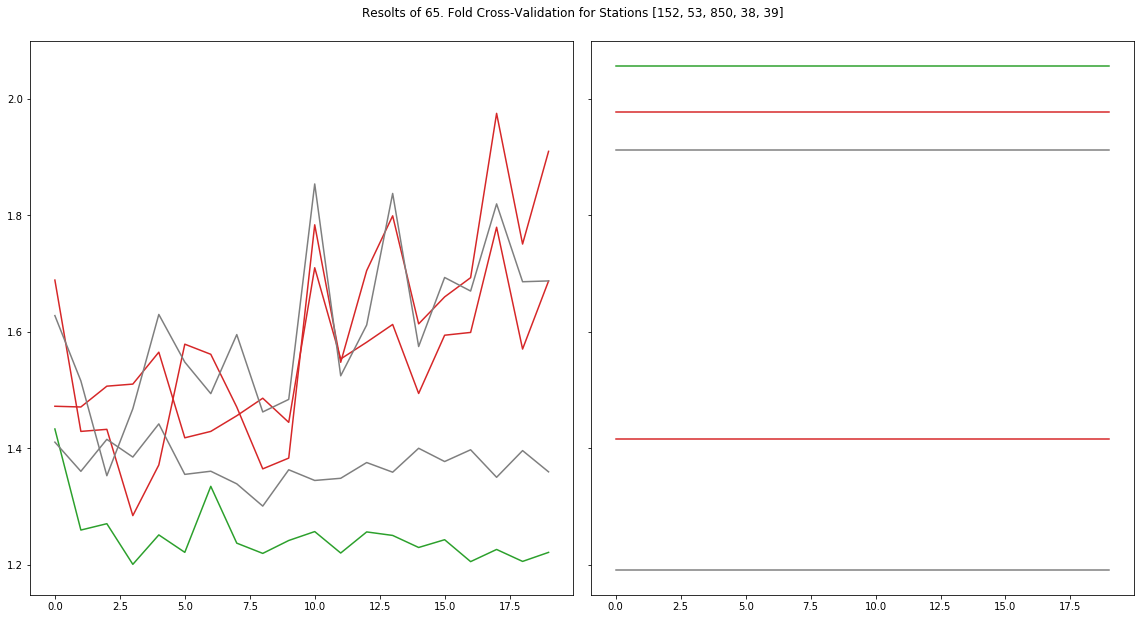

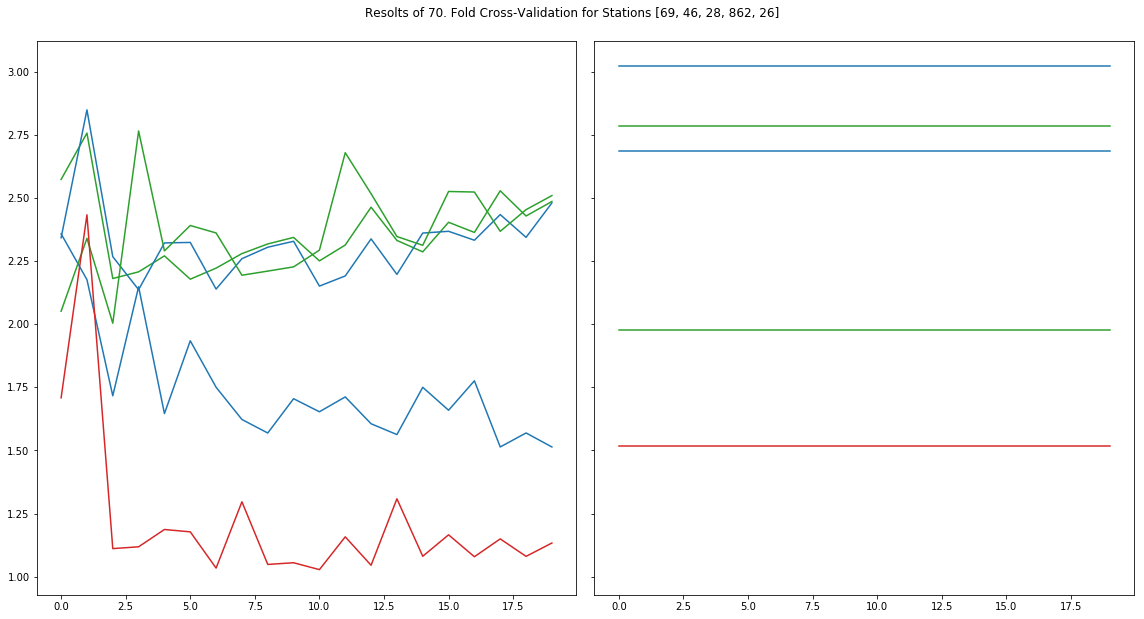

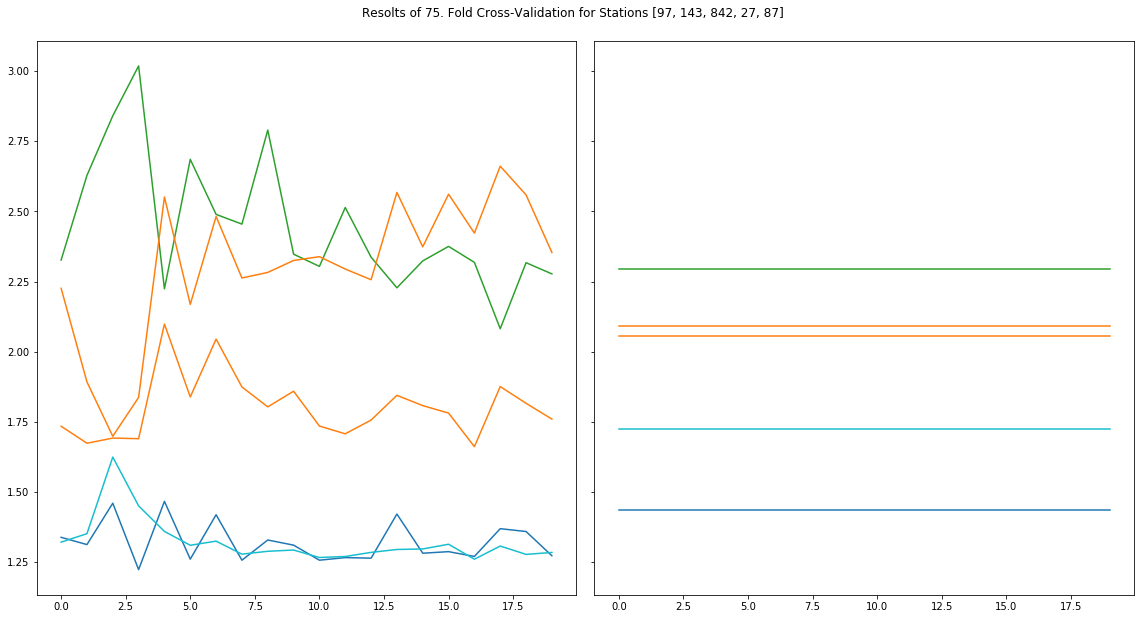

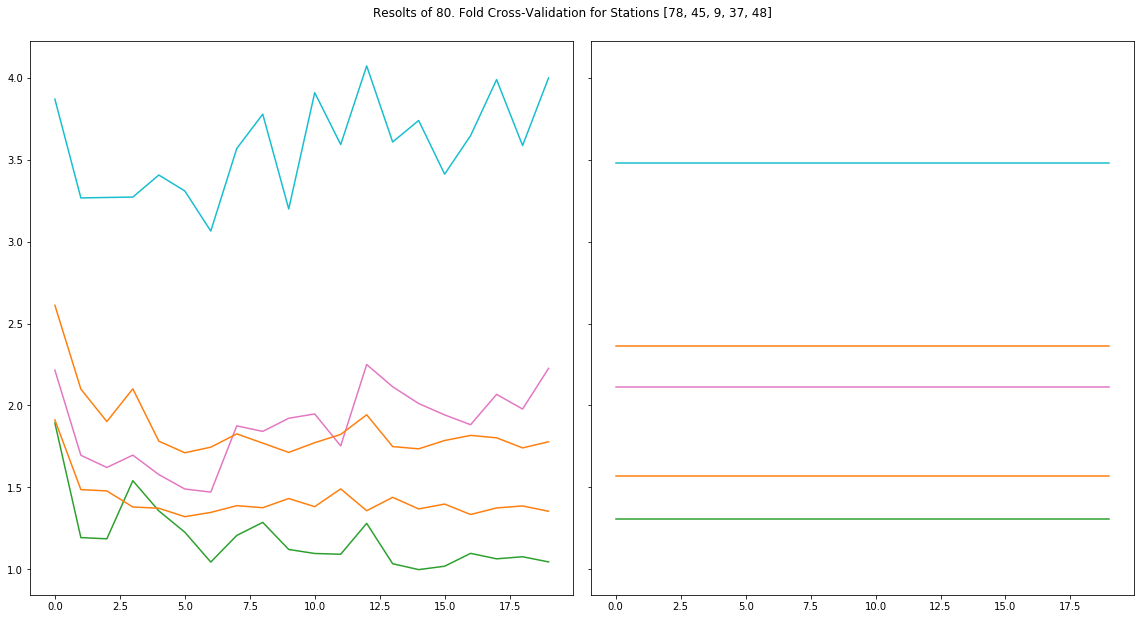

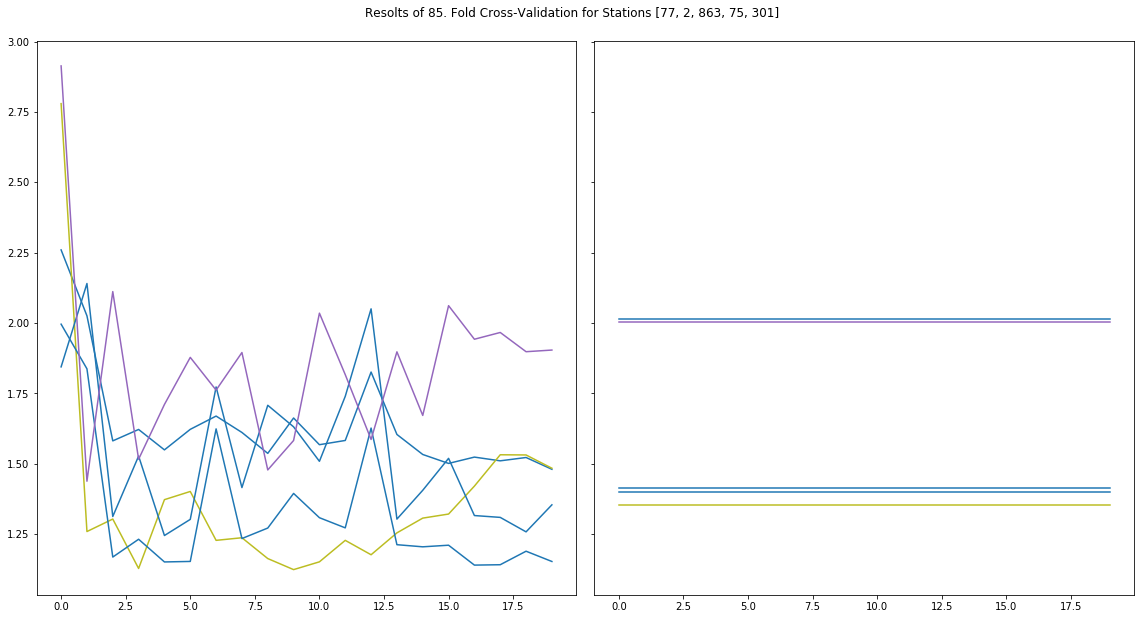

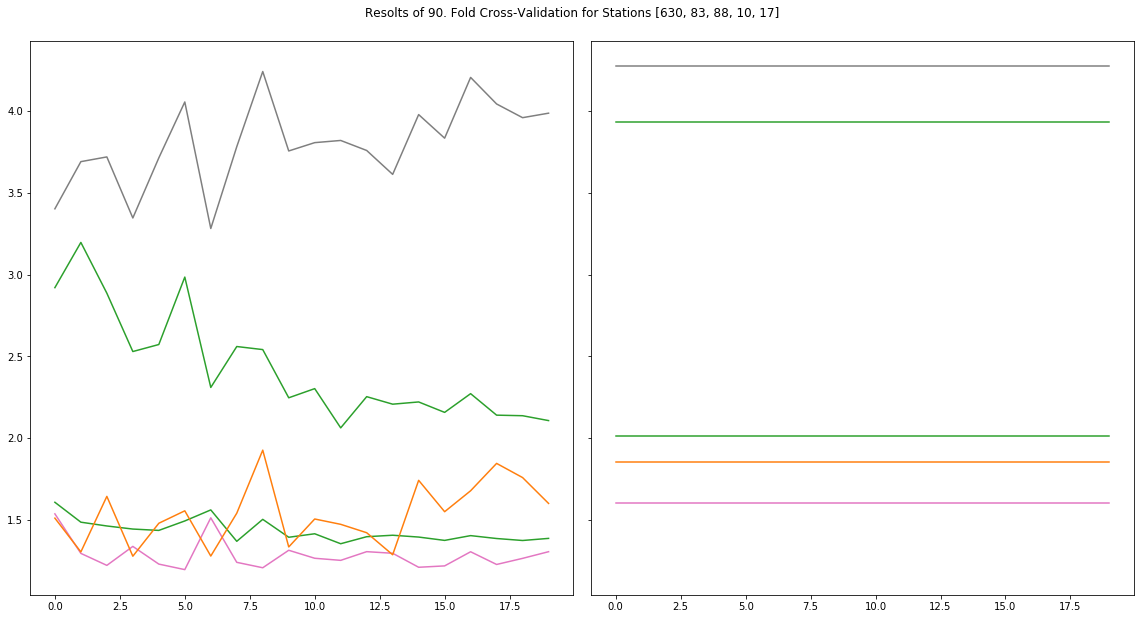

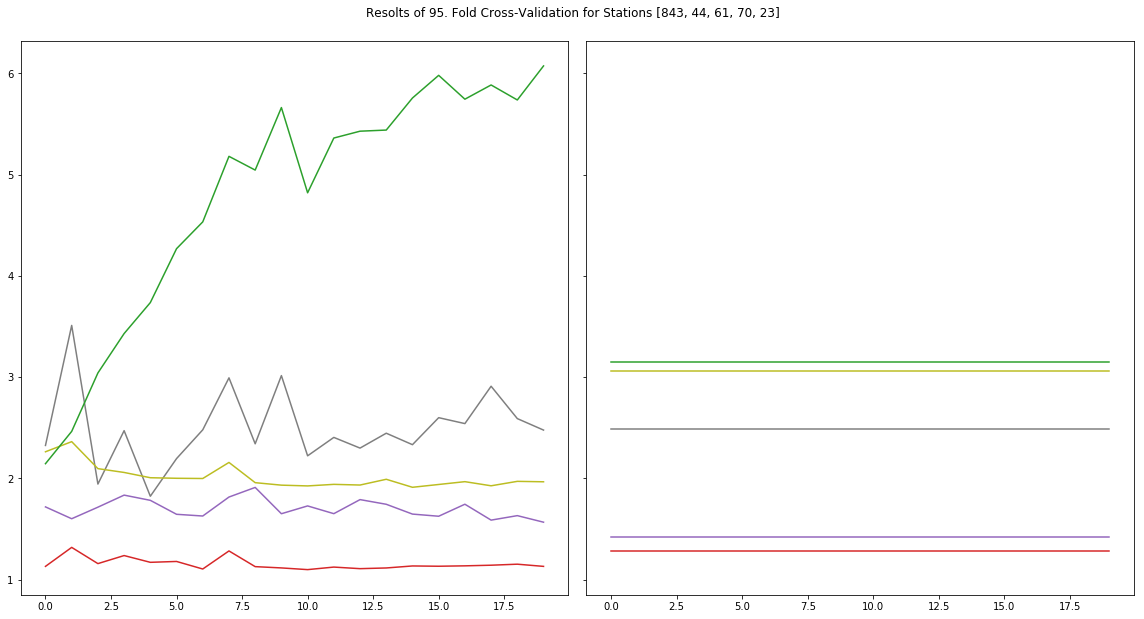

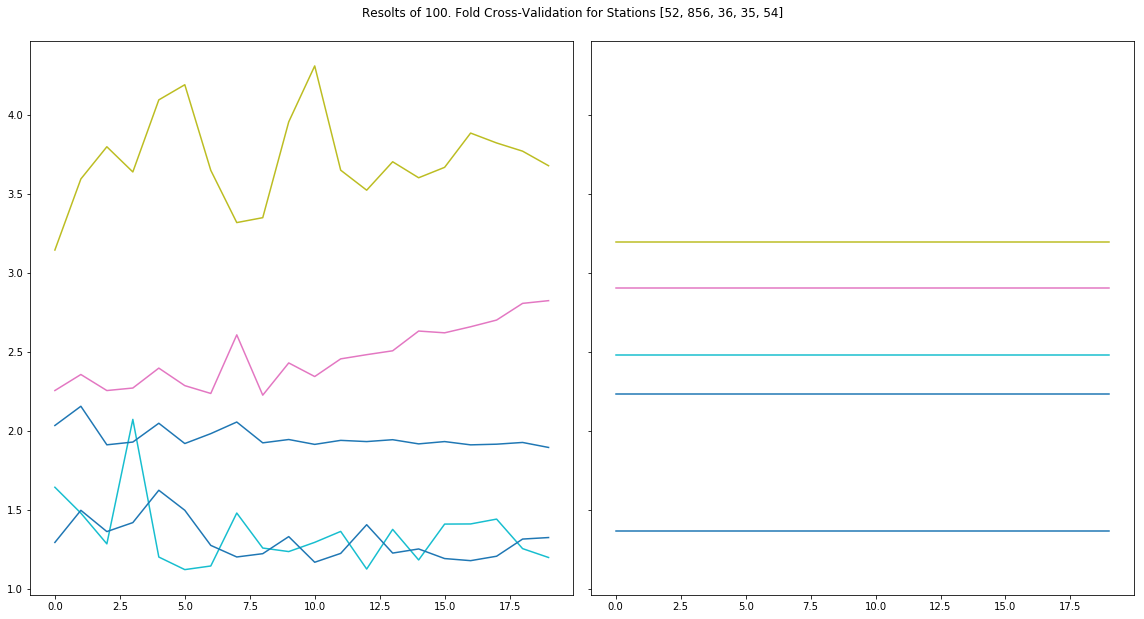

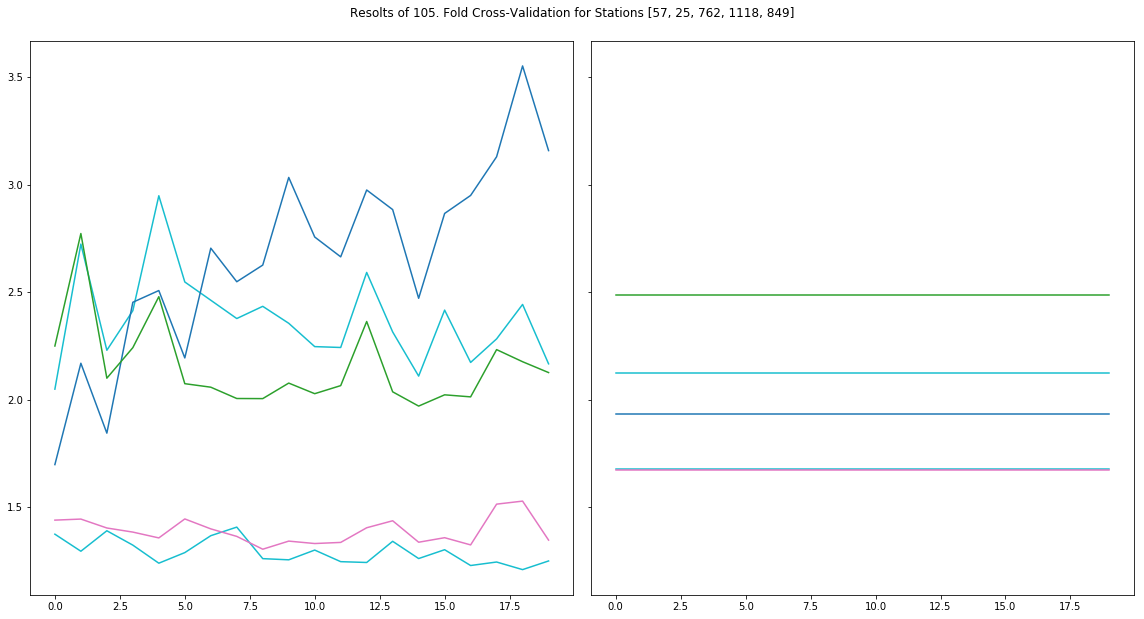

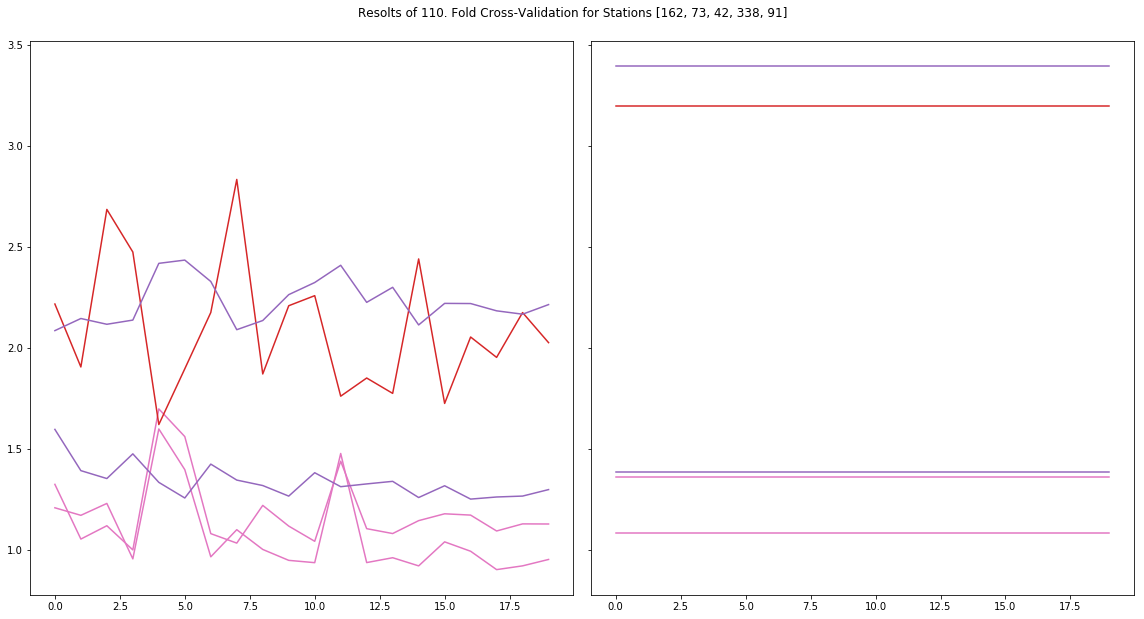

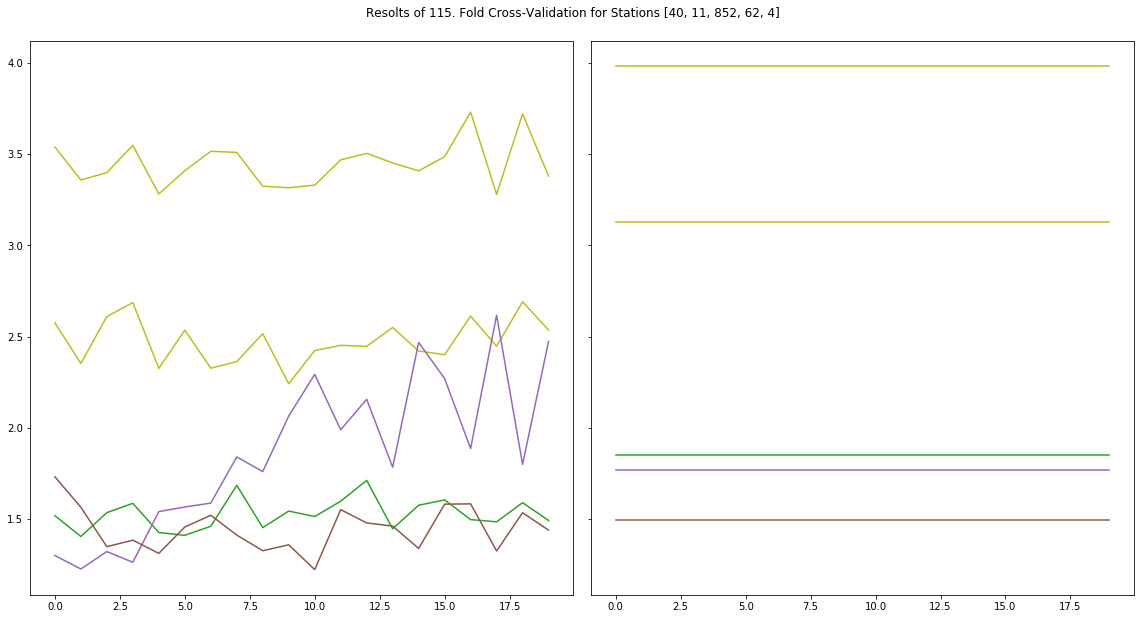

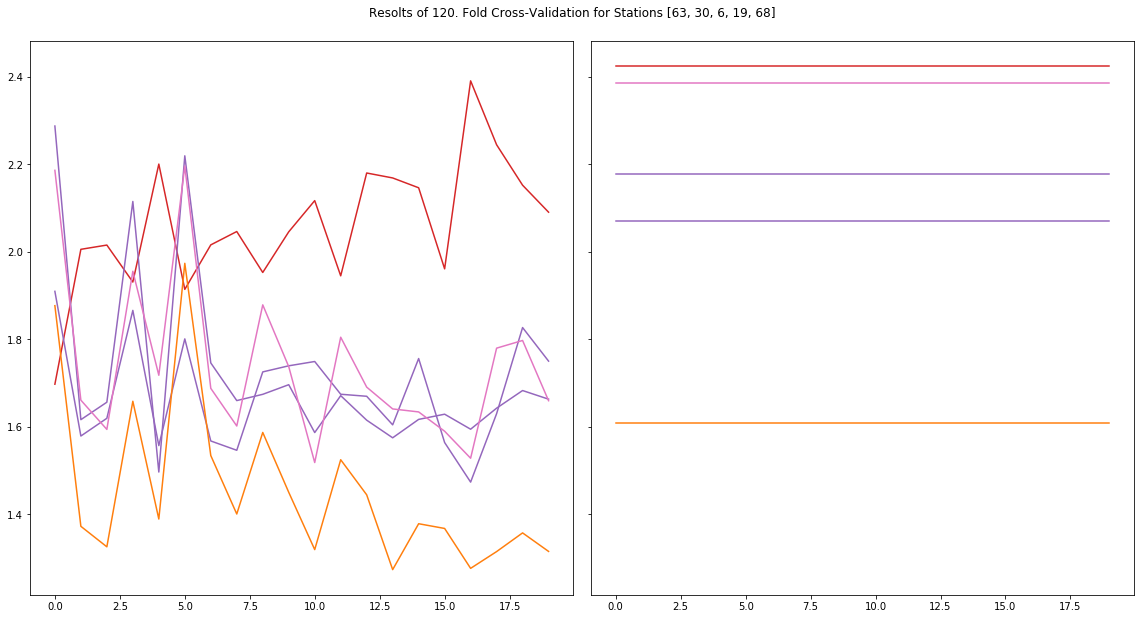

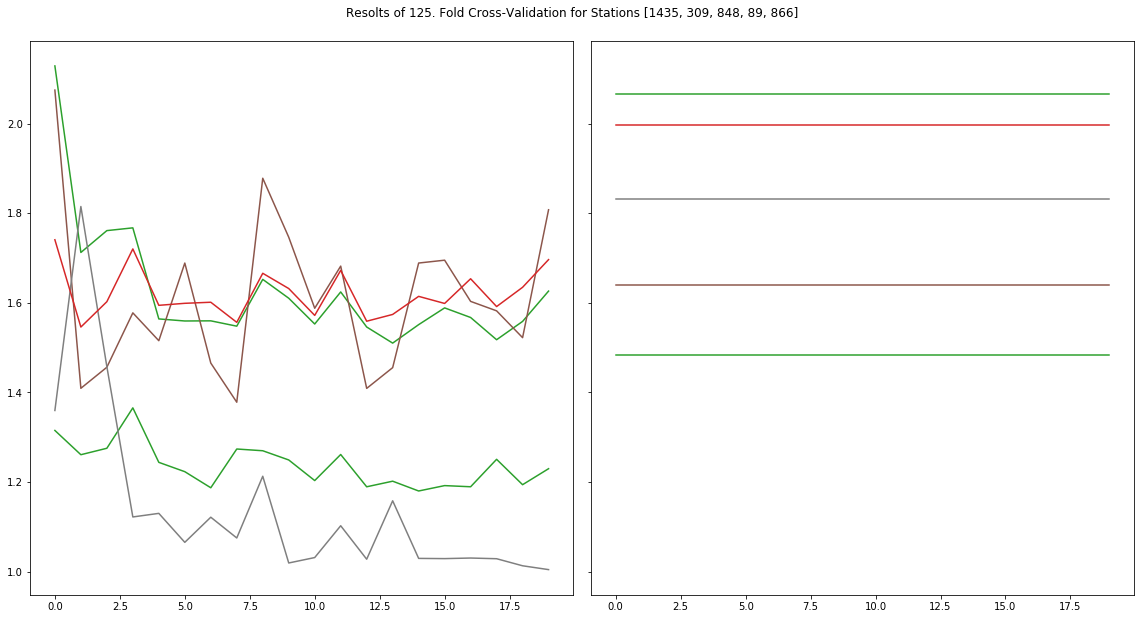

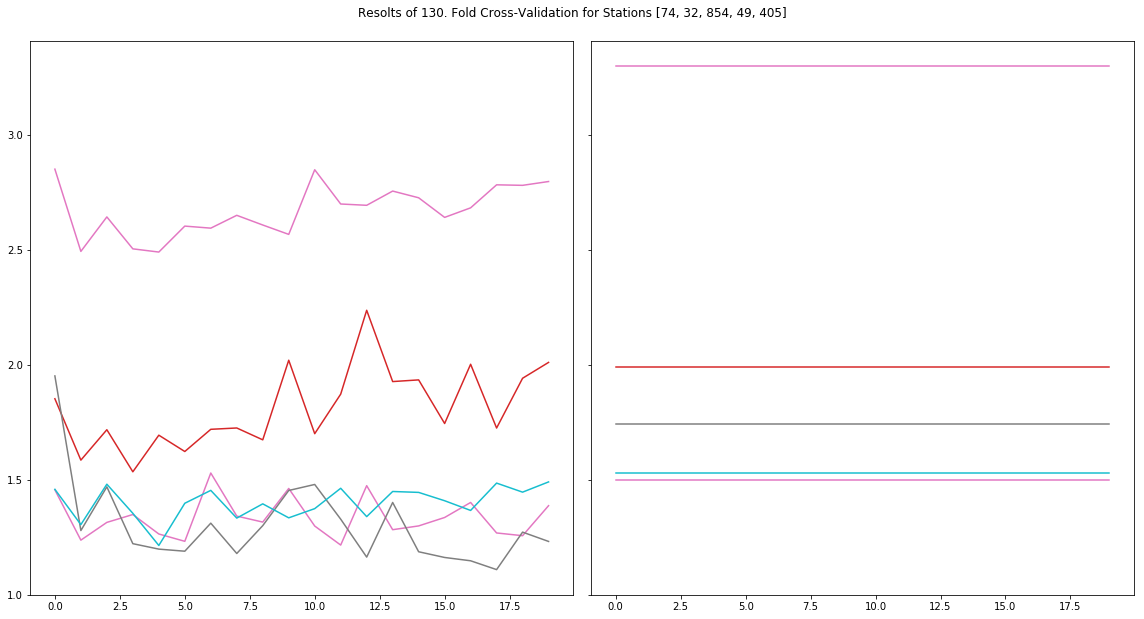

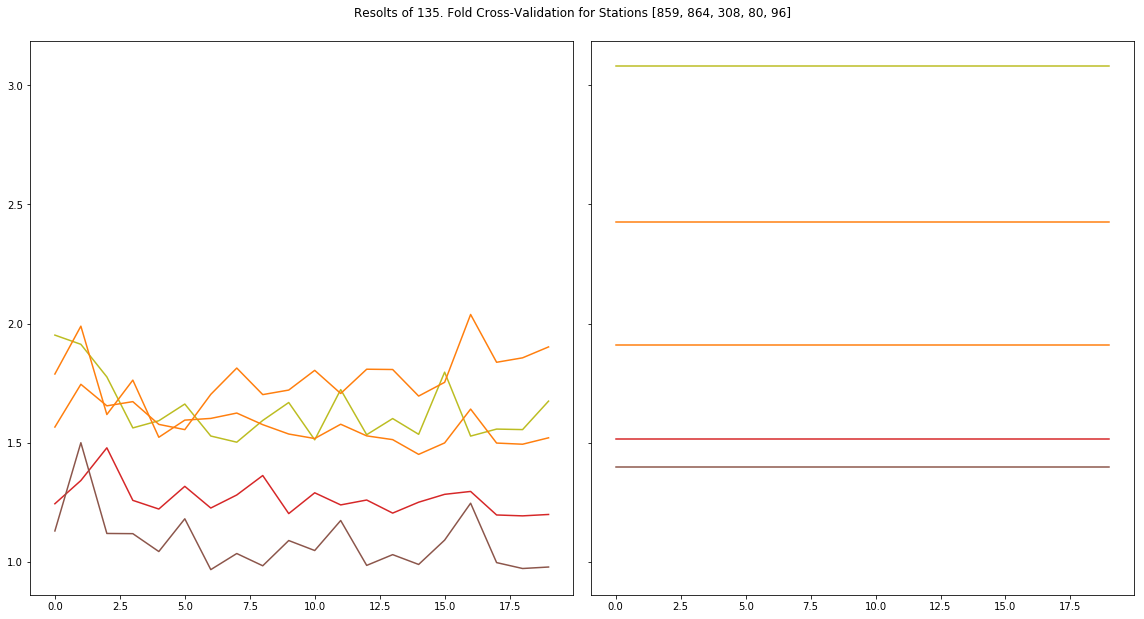

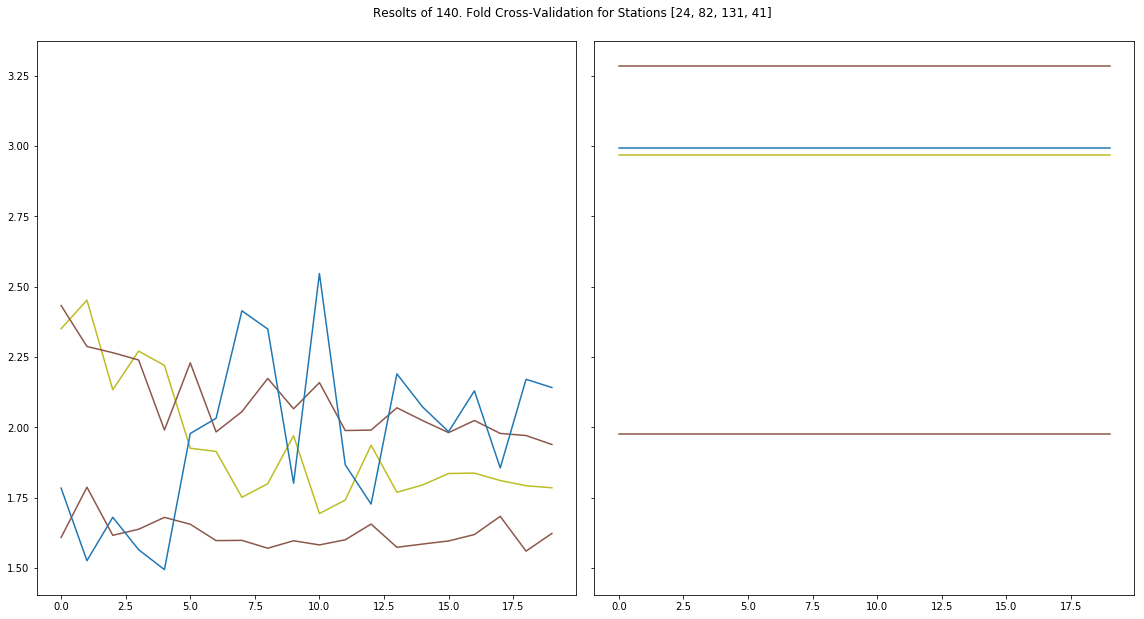

In [13]:
experiment_order_station_ids = []
for first_station in np.arange(0,141,5):
    ds = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/spatial_generalization_experiment/experiment/first_station_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/rmse_per_station.pkl' % first_station,'rb'))
    experiment_statistic = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/spatial_generalization_experiment/experiment/first_station_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/experiment_statistic.pkl' % first_station,'rb'))
    
    experiment_order_station_ids += list(experiment_statistic.attrs['test_stations'])
    
    # only keep entries for existing stations
    reduced_ds = ds.sel(run = 0, station = stations)
    
    # plot results for station fold not used in training
    fig, axes = plt.subplots(1,2, figsize=(16,9), sharex=True, sharey=True)
    axes[0].plot(reduced_ds.data[:,:,0])
    axes[1].plot(reduced_ds.data[:,:,1])
    fig.suptitle('Results of %s. Fold Cross-Validation for Stations %s' % (first_station, list(experiment_statistic.attrs['test_stations'])))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

    try:
        all_data = xr.merge([all_data, reduced_ds.to_dataset(name='per_station_error')], compat='no_conflicts')
    except:
        print('Error')
        all_data = reduced_ds.to_dataset(name='per_station_error')

In [14]:
# calculate mean rmse per epoch and what epoch was the best for each station fold
mean_rmse_per_epoch = np.mean(all_data.per_station_error, axis=1)
best_epoch = np.argmin(mean_rmse_per_epoch[:,0]).item()

In [15]:
all_data.per_station_error[best_epoch,np.argmax(all_data.per_station_error[best_epoch,:,0]).item()].data

array([4.09276869, 3.19493809])

In [21]:
# Calculate maximum increase and decrease from epoc 1 to epoch 20
max_model_error_increase_per_station = np.max(all_data.per_station_error[-1,:,0] - all_data.per_station_error[0,:,0])
max_model_error_decrease_per_station = np.min(all_data.per_station_error[-1,:,0] - all_data.per_station_error[0,:,0])
print("Maximum decrease of model error per station: %.2f" % max_model_error_decrease_per_station)
print("Maximum increase of station error: %.2f" % max_model_error_increase_per_station)

Maximum decrease of model error per station: -1.30
Maximum increase of station error: 3.93


Max. Increase: -1.8697394971758339, Max. Decrease: 2.9250402878455404


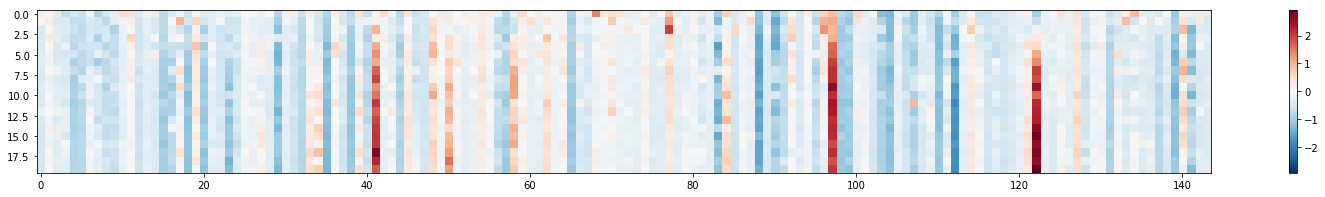

In [16]:
# plot evolution of RMSE over the epochs for each station, when not used in training
plt.figure(figsize=(28,3))
max_decrease = np.max(all_data.per_station_error[:,:,0] - all_data.per_station_error[:,:,1]).item()
max_increase = np.min(all_data.per_station_error[:,:,0] - all_data.per_station_error[:,:,1]).item()
print("Max. Increase: %s, Max. Decrease: %s" % (max_increase, max_decrease))
max_absolute_change = np.maximum(np.absolute(max_decrease), np.absolute(max_increase))
plt.imshow(all_data.per_station_error[:,:,0] - all_data.per_station_error[:,:,1], cmap='RdBu_r',
           vmin=-max_absolute_change, vmax=max_absolute_change)
plt.colorbar()
plt.show()

### Plot results of cross-validation experiment without dropout

Epoch: 0, Model RMSE: 1.933, COSMO RMSE: 2.134, FS: 9.42%, Worst 0 Stations: [], Worst 1 Station: 141
Epoch: 1, Model RMSE: 1.868, COSMO RMSE: 2.134, FS: 12.46%, Worst 0 Stations: [], Worst 1 Station: 141
Epoch: 2, Model RMSE: 1.836, COSMO RMSE: 2.134, FS: 13.95%, Worst 0 Stations: [], Worst 1 Station: 48
Epoch: 3, Model RMSE: 1.817, COSMO RMSE: 2.134, FS: 14.88%, Worst 0 Stations: [], Worst 1 Station: 48
Epoch: 4, Model RMSE: 1.814, COSMO RMSE: 2.134, FS: 15.01%, Worst 0 Stations: [], Worst 1 Station: 48
Epoch: 5, Model RMSE: 1.819, COSMO RMSE: 2.134, FS: 14.76%, Worst 0 Stations: [], Worst 1 Station: 122
Epoch: 6, Model RMSE: 1.815, COSMO RMSE: 2.134, FS: 14.96%, Worst 0 Stations: [], Worst 1 Station: 122
Epoch: 7, Model RMSE: 1.852, COSMO RMSE: 2.134, FS: 13.20%, Worst 0 Stations: [], Worst 1 Station: 122
Epoch: 8, Model RMSE: 1.839, COSMO RMSE: 2.134, FS: 13.81%, Worst 0 Stations: [], Worst 1 Station: 122
Epoch: 9, Model RMSE: 1.822, COSMO RMSE: 2.134, FS: 14.65%, Worst 0 Stations:

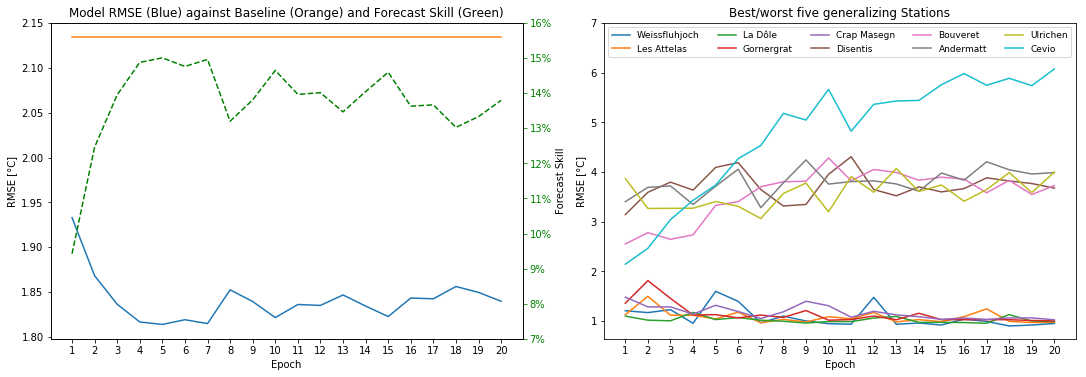

In [23]:
n_stations = 144
n_stations_taken = 144
best_forecast_skill = (0, 0)
per_epoch_rmse_data = np.zeros((20,3))
epoch_station_error = all_data.per_station_error
for epoch, station_error in enumerate(epoch_station_error):
    station_error = station_error.data
    sorted_stations = list(np.argsort(station_error[:,0]))
    best_stations = sorted_stations[:n_stations_taken]
    worst_stations = sorted_stations[n_stations_taken:]
    
    mean_rmse_model = np.mean(station_error[best_stations,0])
    mean_rmse_cosmo = np.mean(station_error[best_stations,1])
    
    forecast_skill = (1-(mean_rmse_model/mean_rmse_cosmo))*100
    
    if forecast_skill > best_forecast_skill[1]:
        best_forecast_skill = (epoch, forecast_skill)
    print('Epoch: %s, Model RMSE: %.3f, COSMO RMSE: %.3f, FS: %.2f%%, Worst %s Stations: %s, Worst 1 Station: %s' % (epoch,
                                                                                mean_rmse_model,
                                                                                mean_rmse_cosmo,
                                                                                forecast_skill,
                                                                                n_stations-n_stations_taken,
                                                                                worst_stations,
                                                                                sorted_stations[-1]))
    per_epoch_rmse_data[epoch] = np.array((mean_rmse_model, mean_rmse_cosmo, forecast_skill))
    
print('Best Epoch: %s, Forecast Skill (FS): %.2f%%' % best_forecast_skill)

fig, ax = plt.subplots(1,2, figsize=(16,6), sharex=True)
ax[0].plot(per_epoch_rmse_data[:,:2])
ax[0].set_ylabel('RMSE [°C]')
ax[0].set_xlabel('Epoch')
ax[0].set_xticks(range(0,20))
ax[0].set_xticklabels(range(1,21))

ax2 = ax[0].twinx()
ax2.plot(per_epoch_rmse_data[:,2], 'g--')
ax2.set_ylabel('Forecast Skill')
ax2.set_yticks(np.arange(7,17))
ax2.set_yticklabels(['%i%%' % fs for fs in np.arange(7,17)])
ax2.tick_params('y', colors='g')

ax[0].set_title('Model RMSE (Blue) against Baseline (Orange) and Forecast Skill (Green)')


# print test error by epoch for best and worst 5 stations after 20 epochs

# get idx of stations in experiment ordering of stations
best_5_stations_epoch_20 = sorted_stations[:5]
worst_5_stations_epoch_20 = sorted_stations[-5:]

ax[1].plot(epoch_station_error[:, best_5_stations_epoch_20 + worst_5_stations_epoch_20, 0])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('RMSE [°C]')
ax[1].set_ylim(top=7)
ax[1].legend([station_names[s].item() for s in best_5_stations_epoch_20 + worst_5_stations_epoch_20], loc="upper left", ncol=5, fontsize=9)
ax[1].set_title('Best/worst five generalizing Stations')
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

### Results with dropout

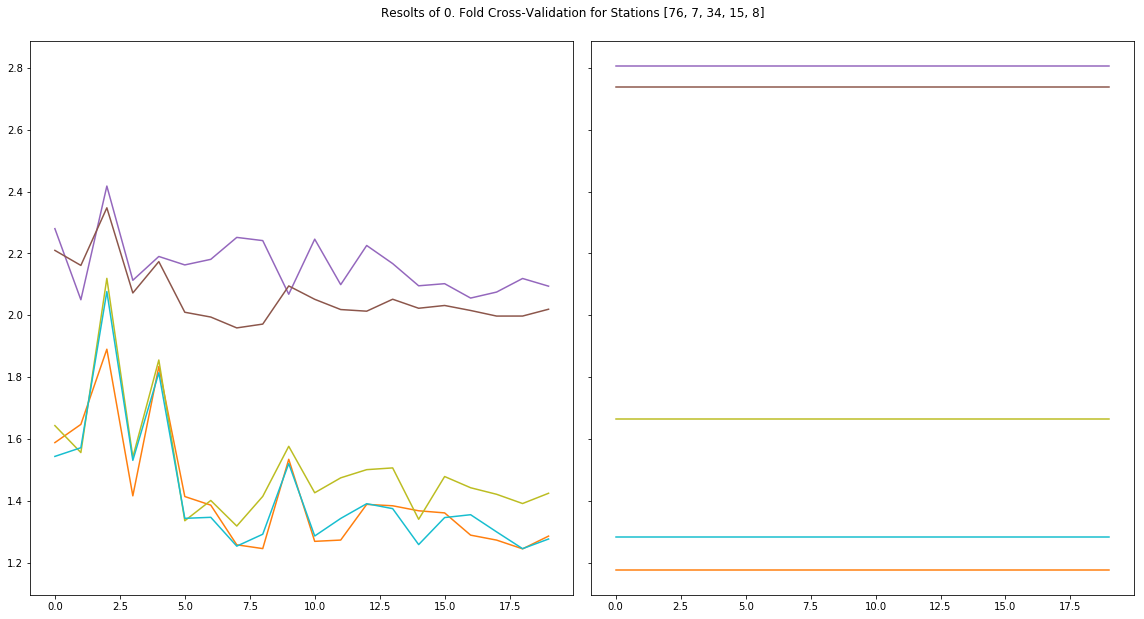

Error


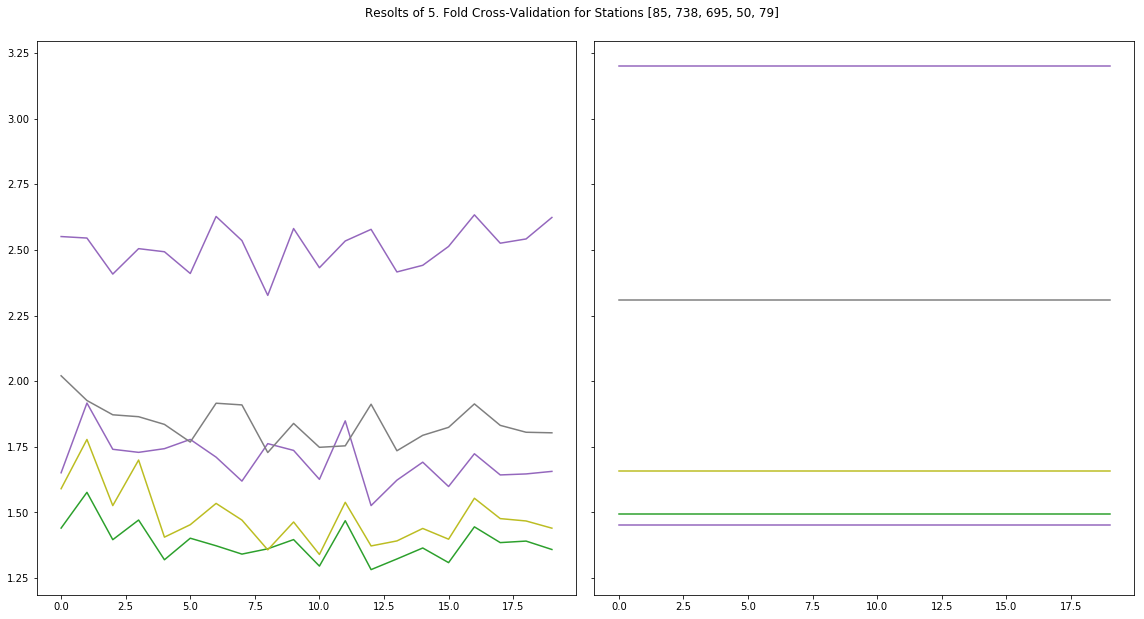

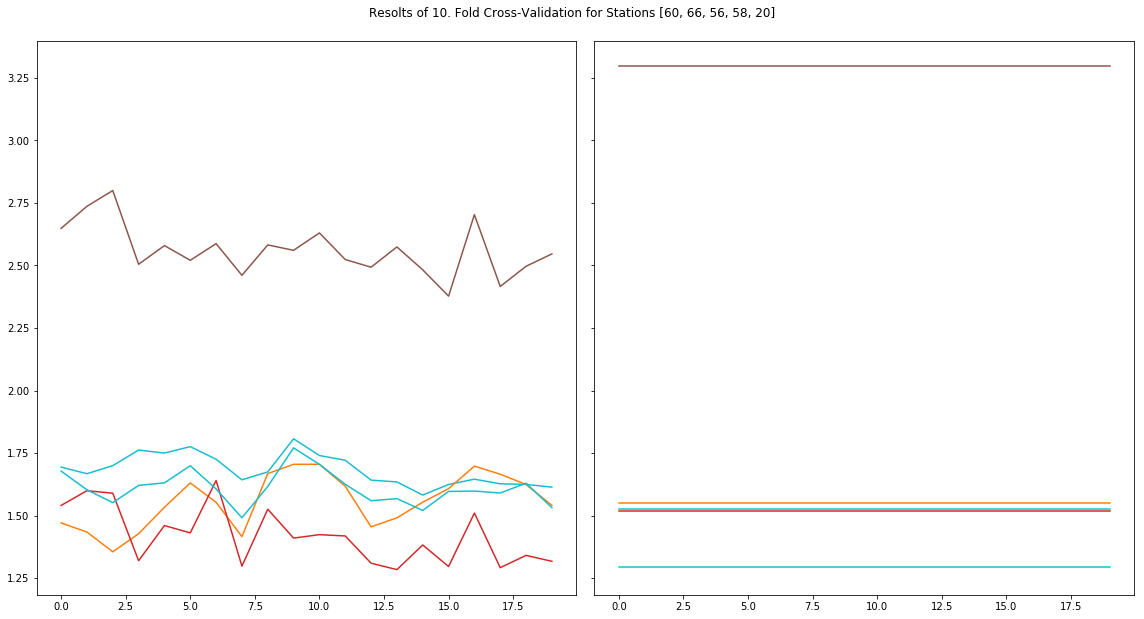

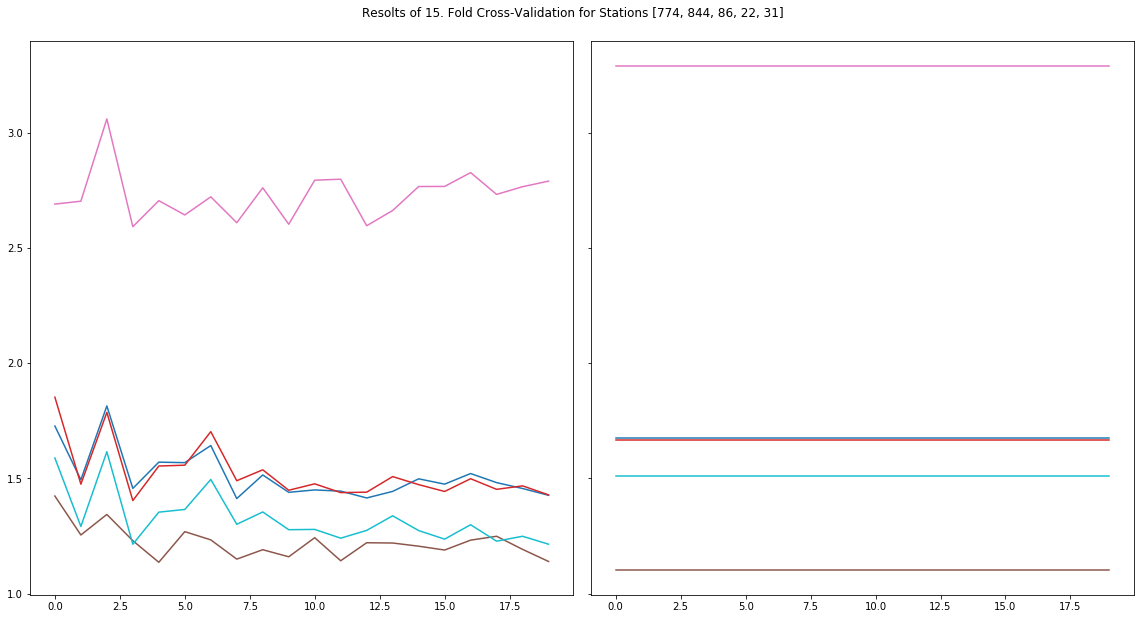

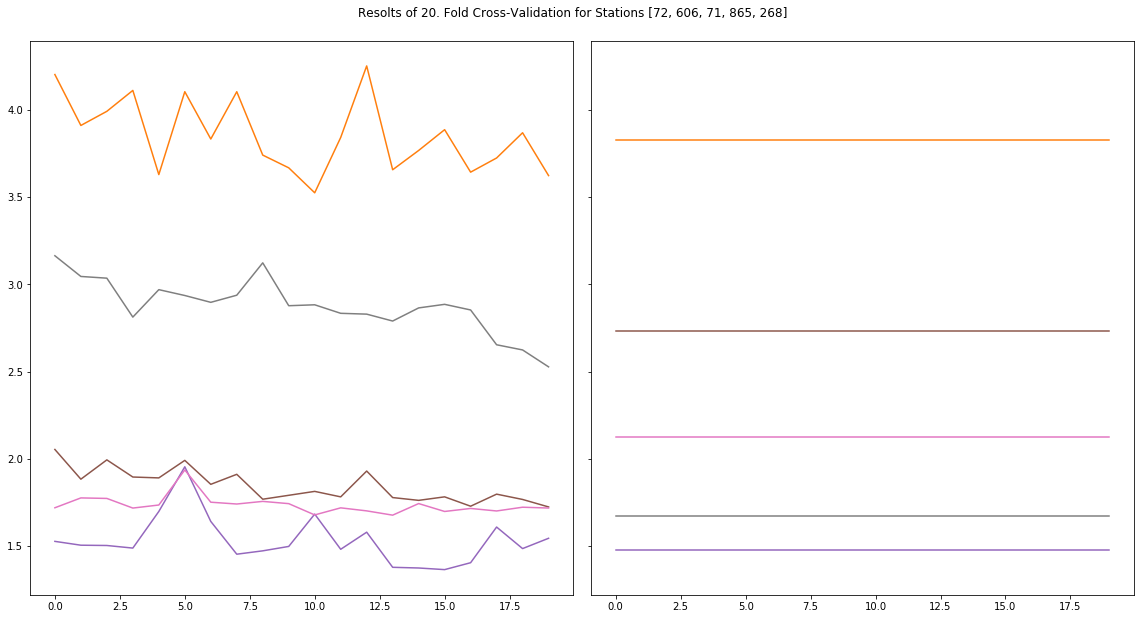

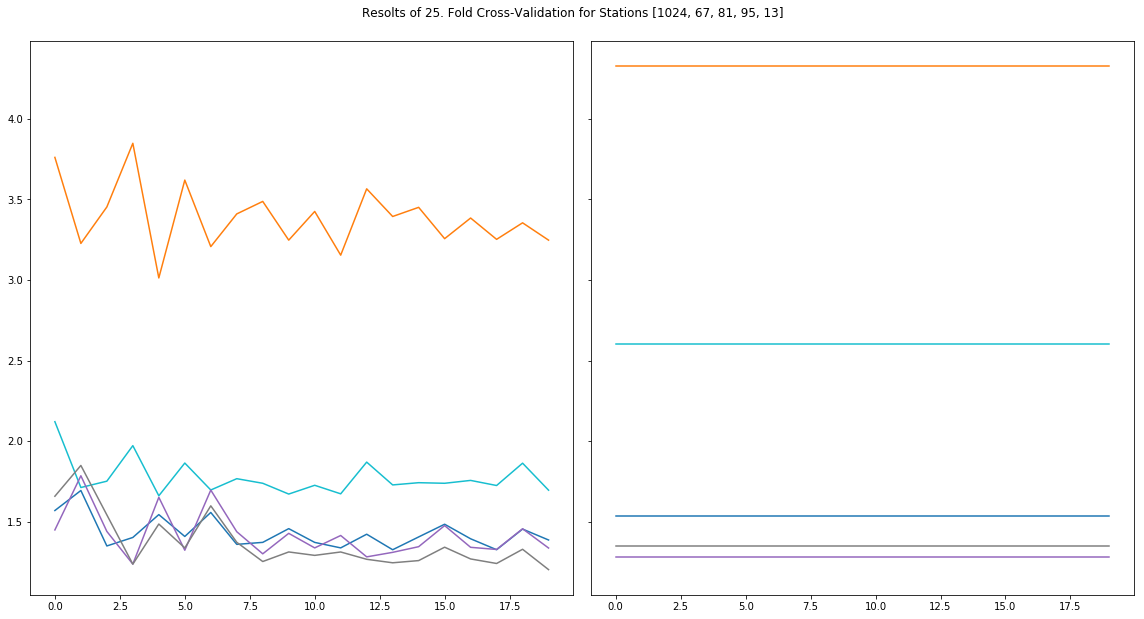

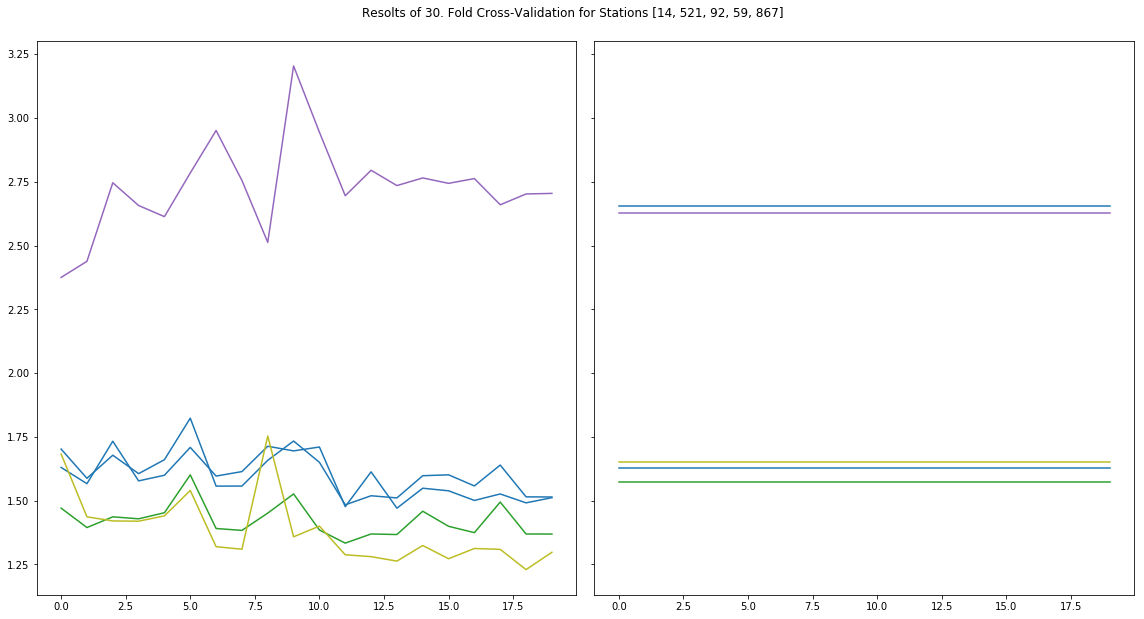

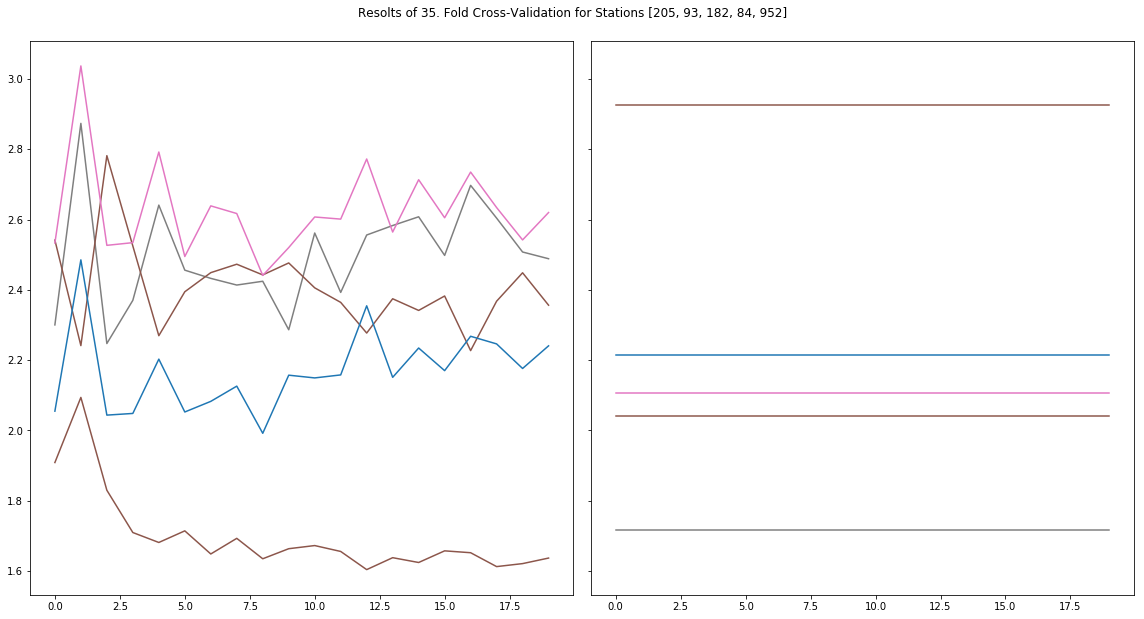

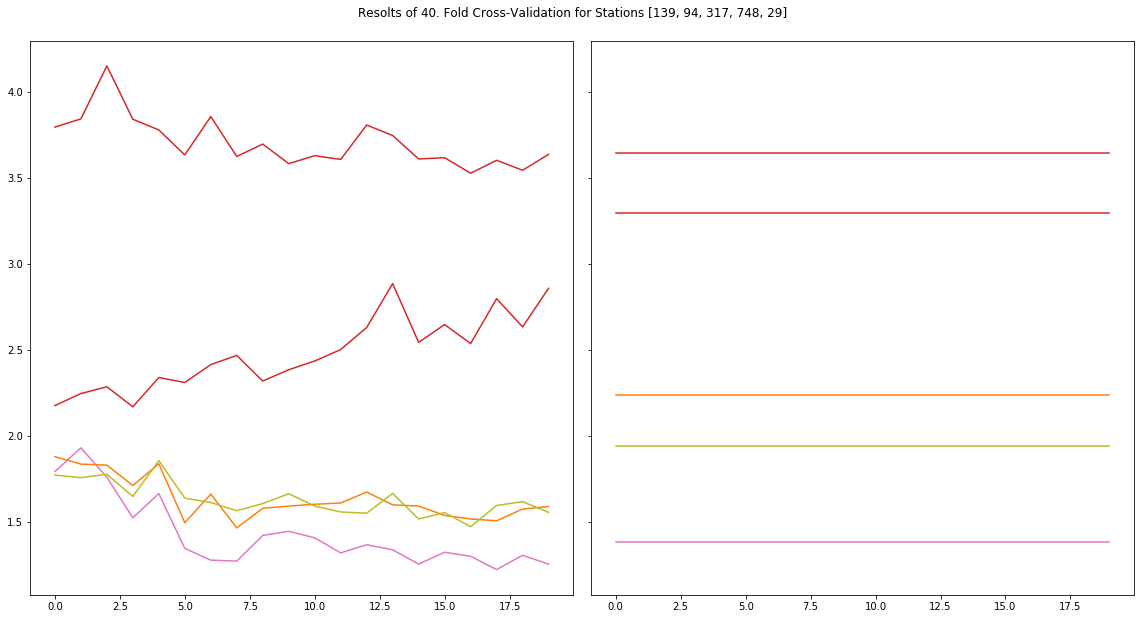

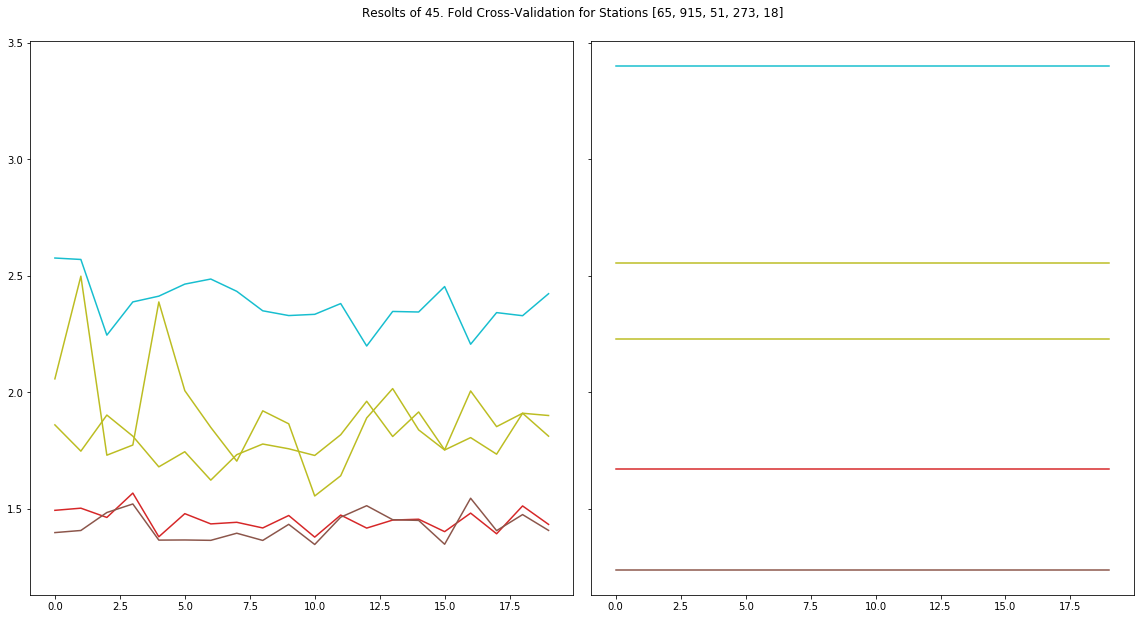

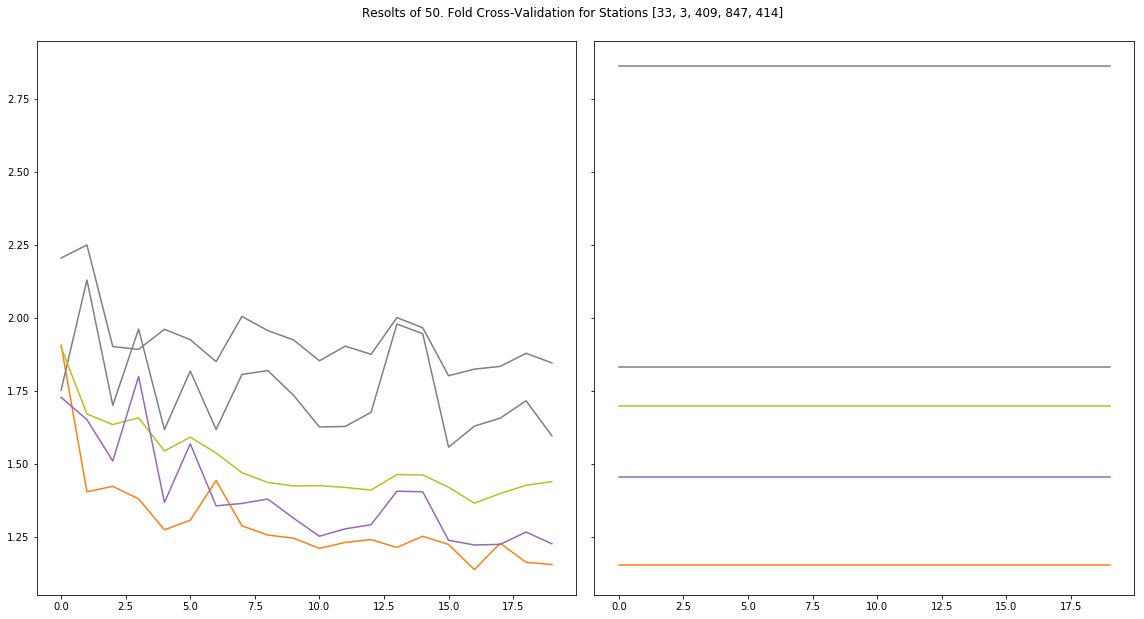

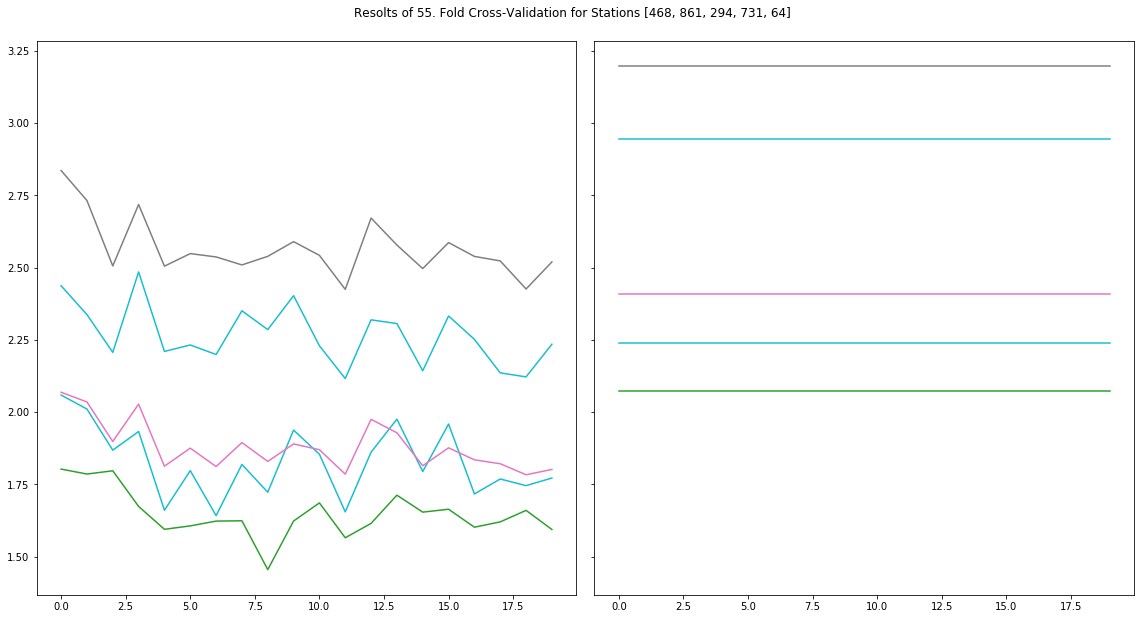

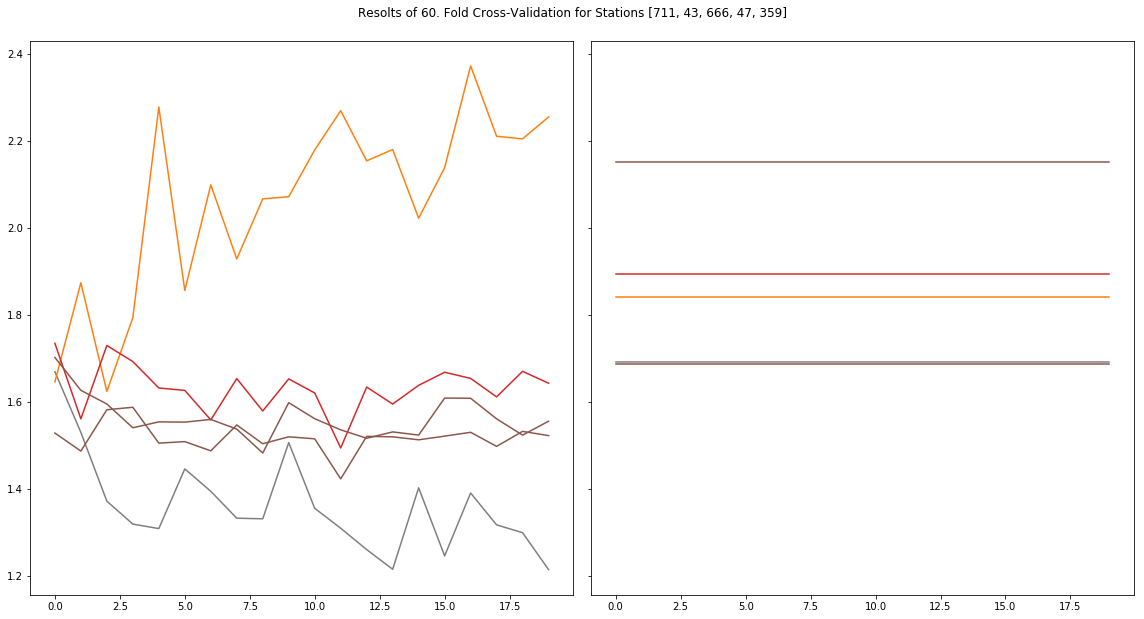

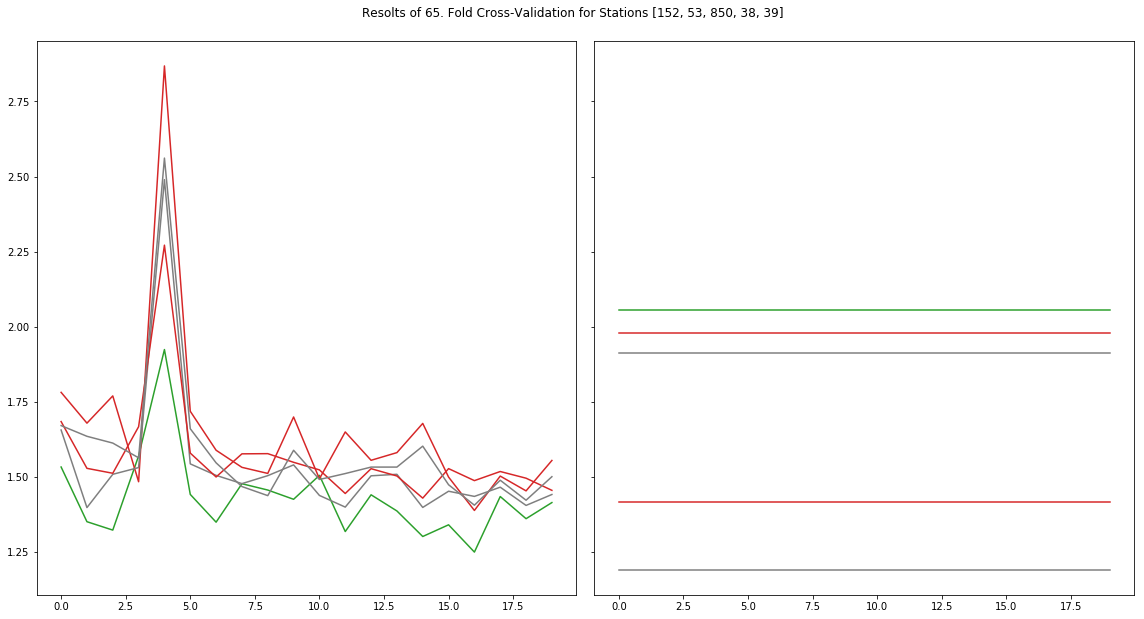

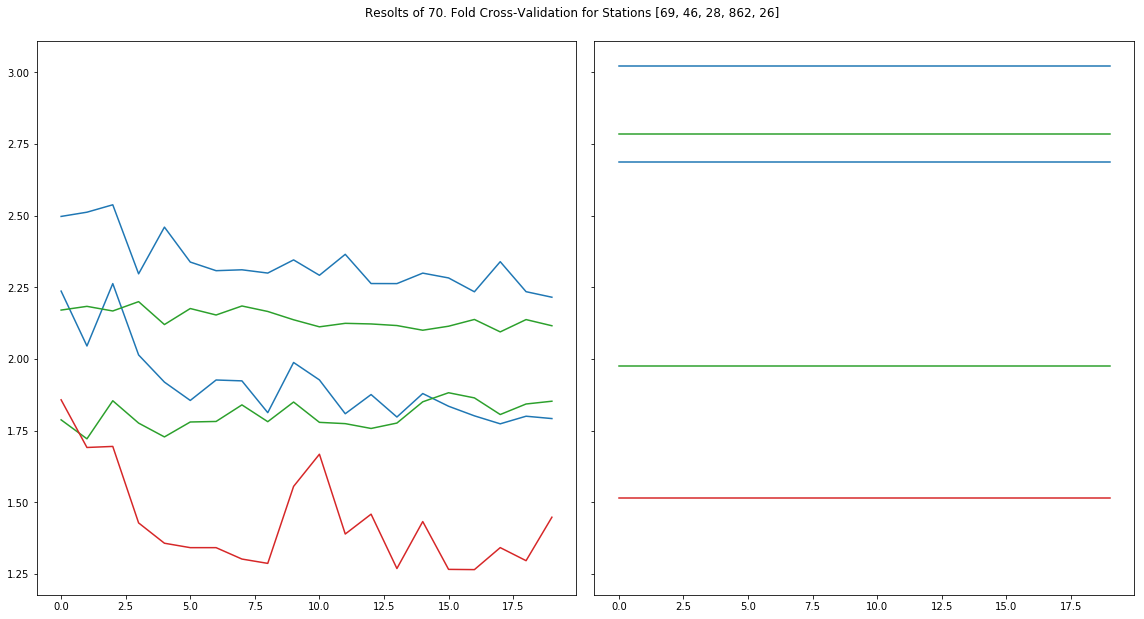

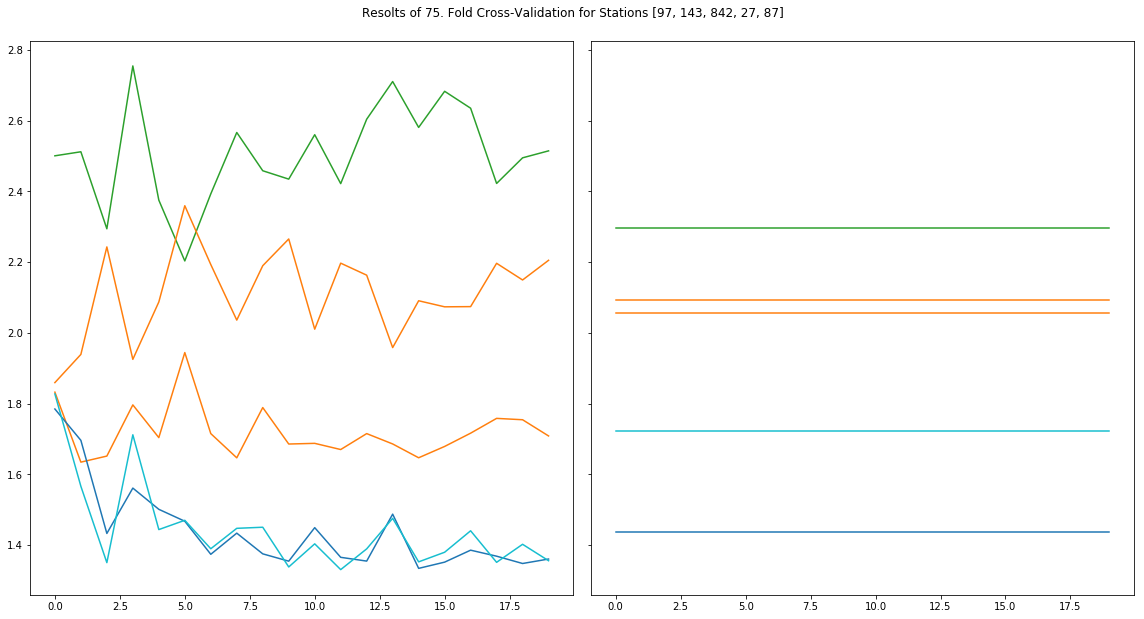

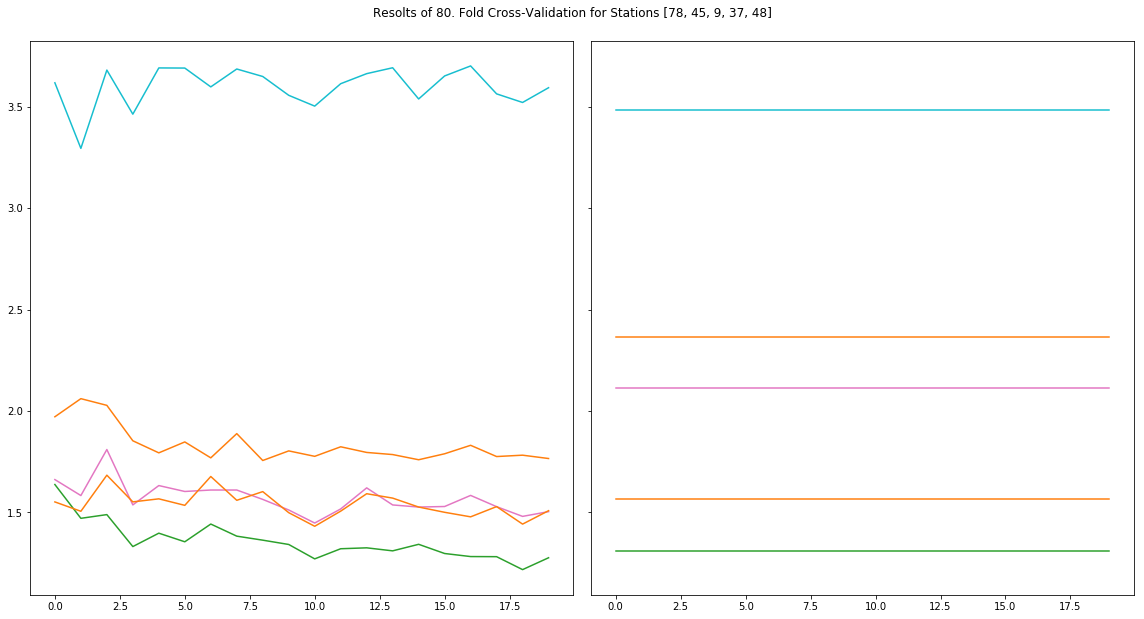

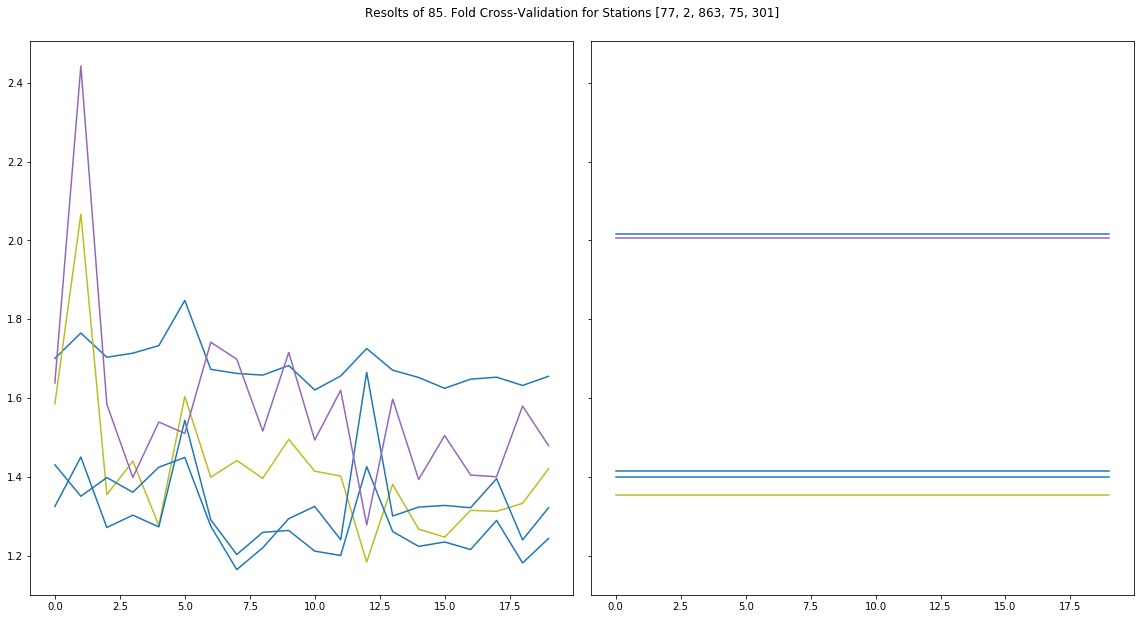

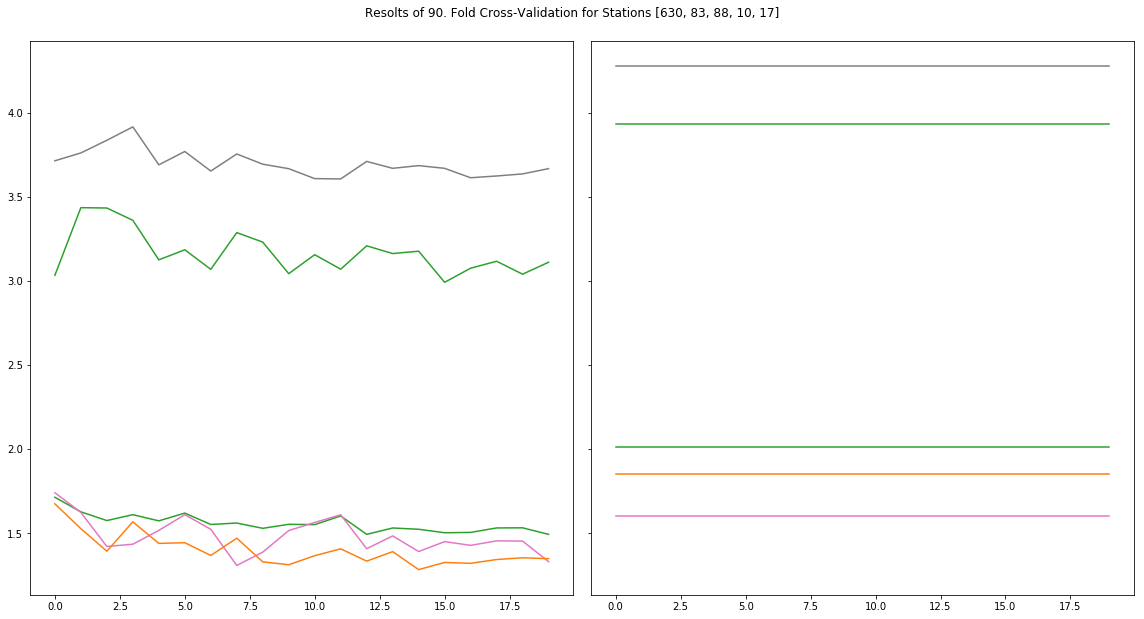

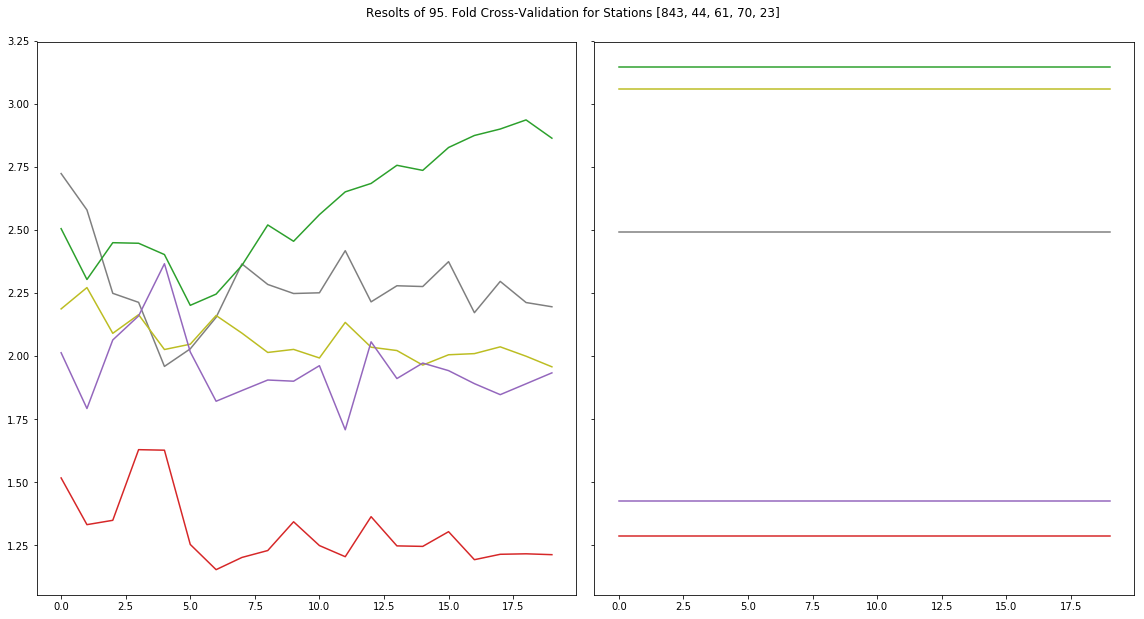

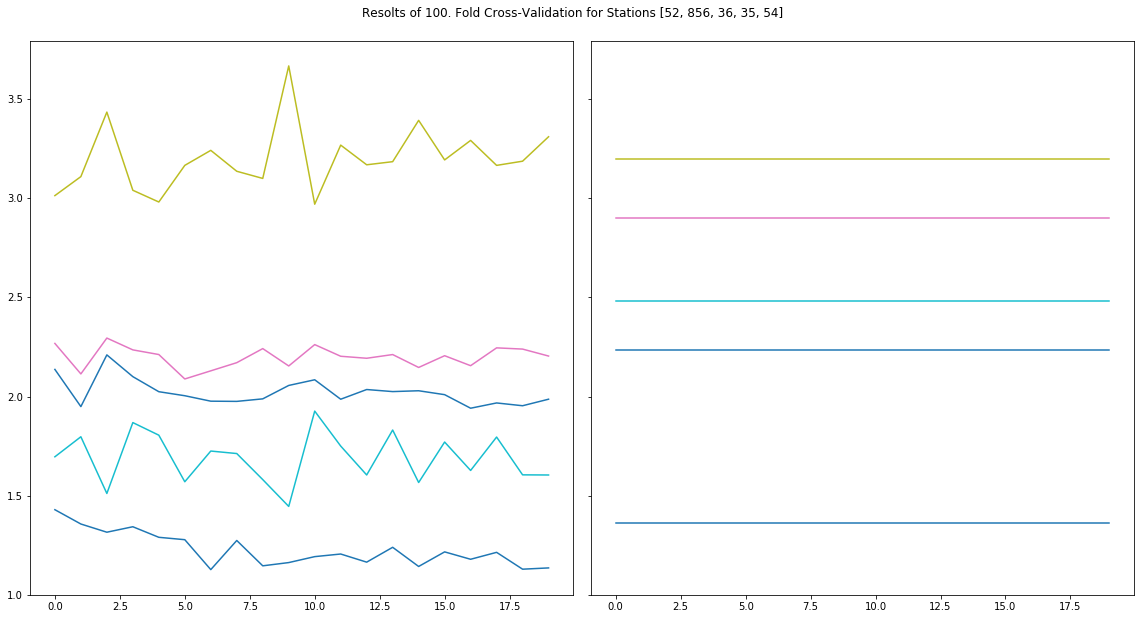

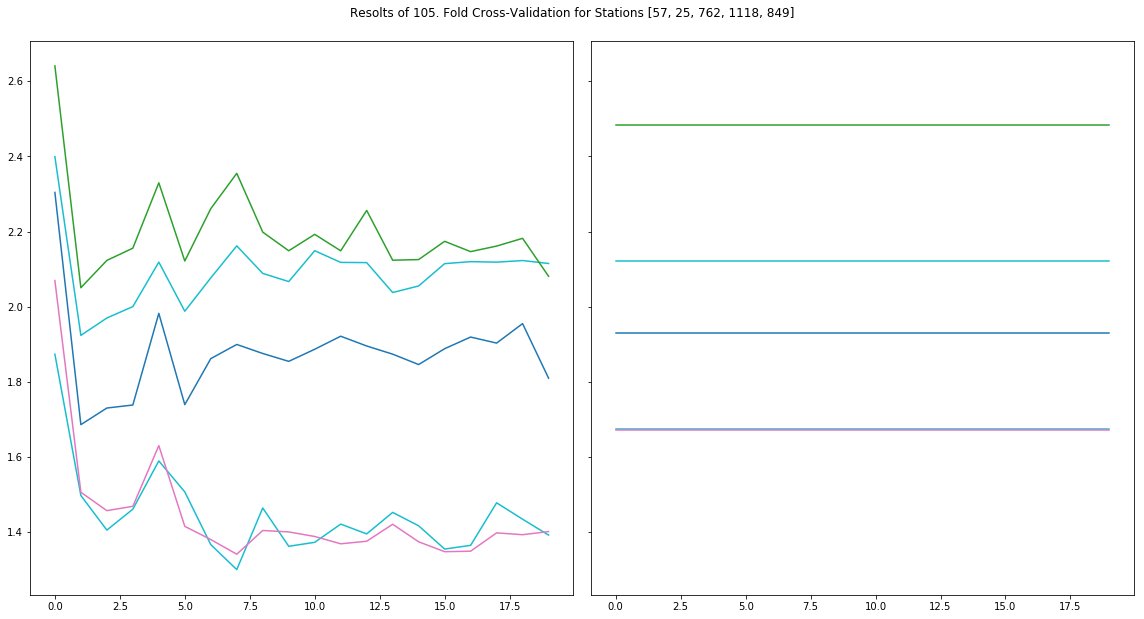

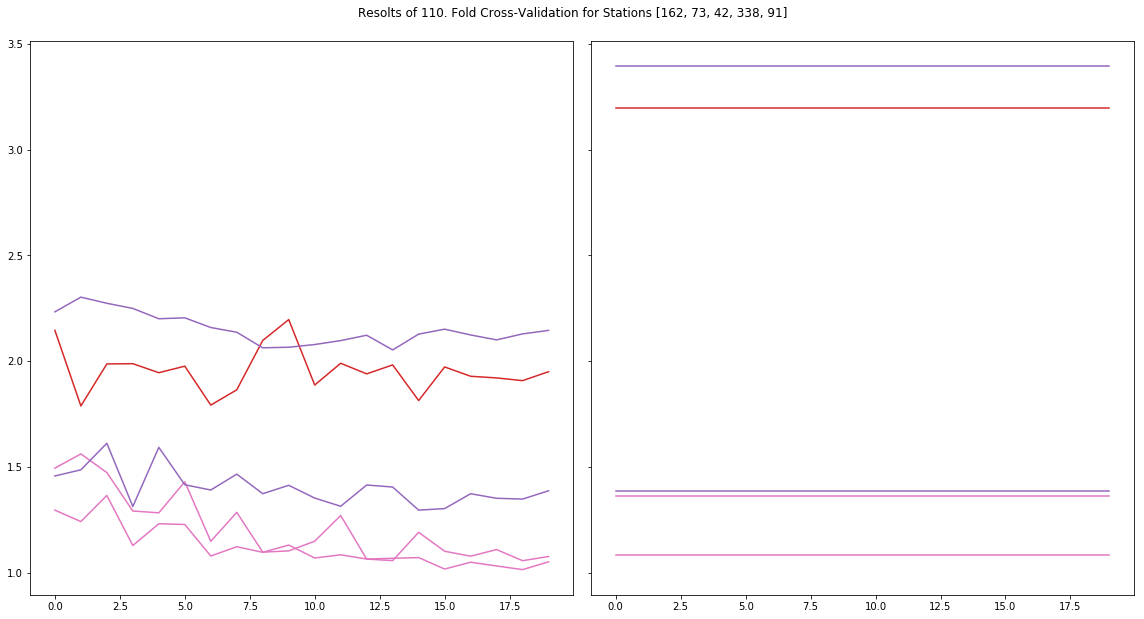

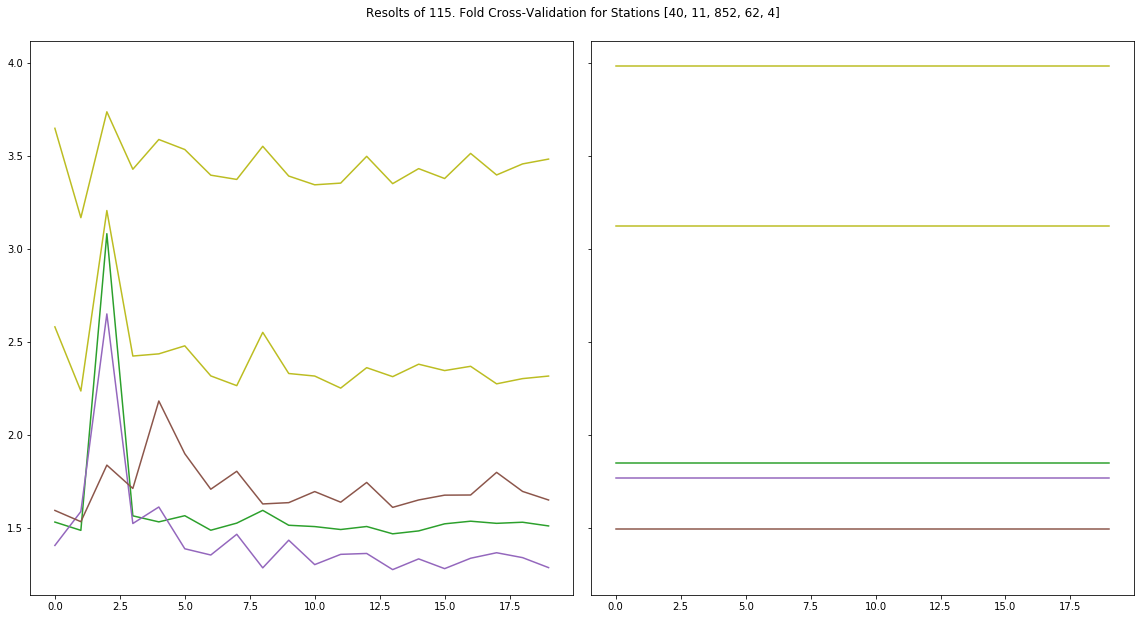

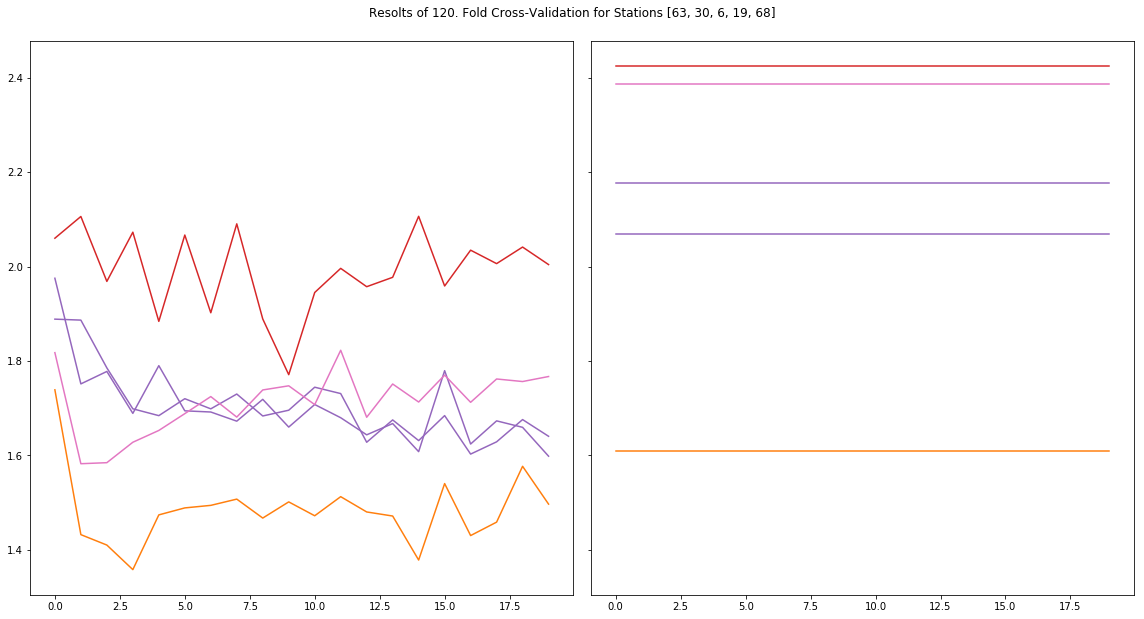

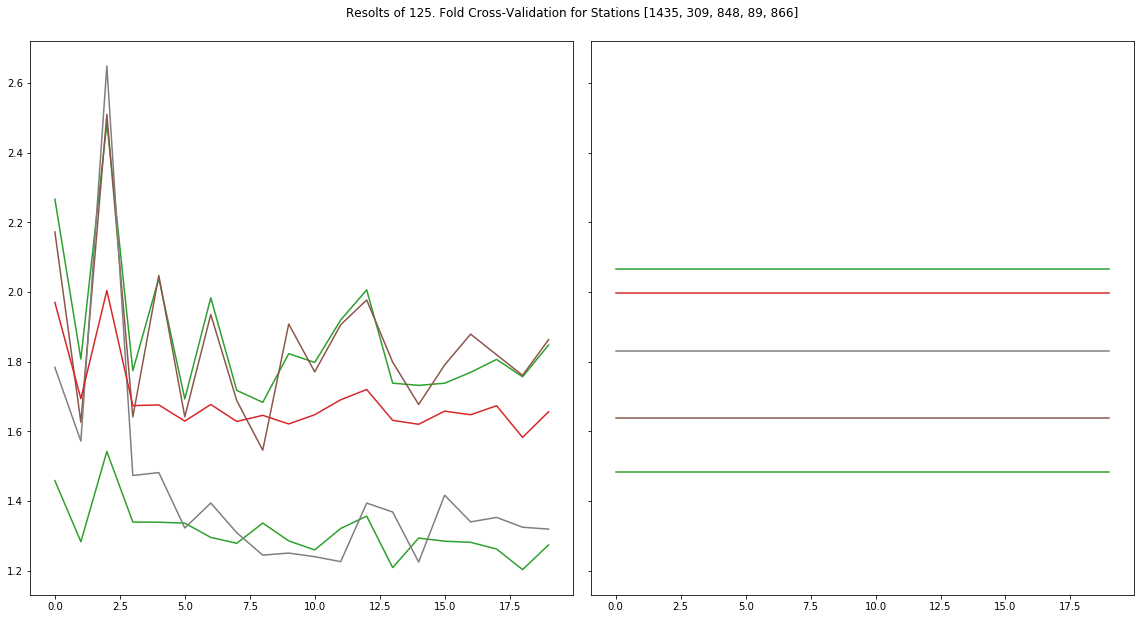

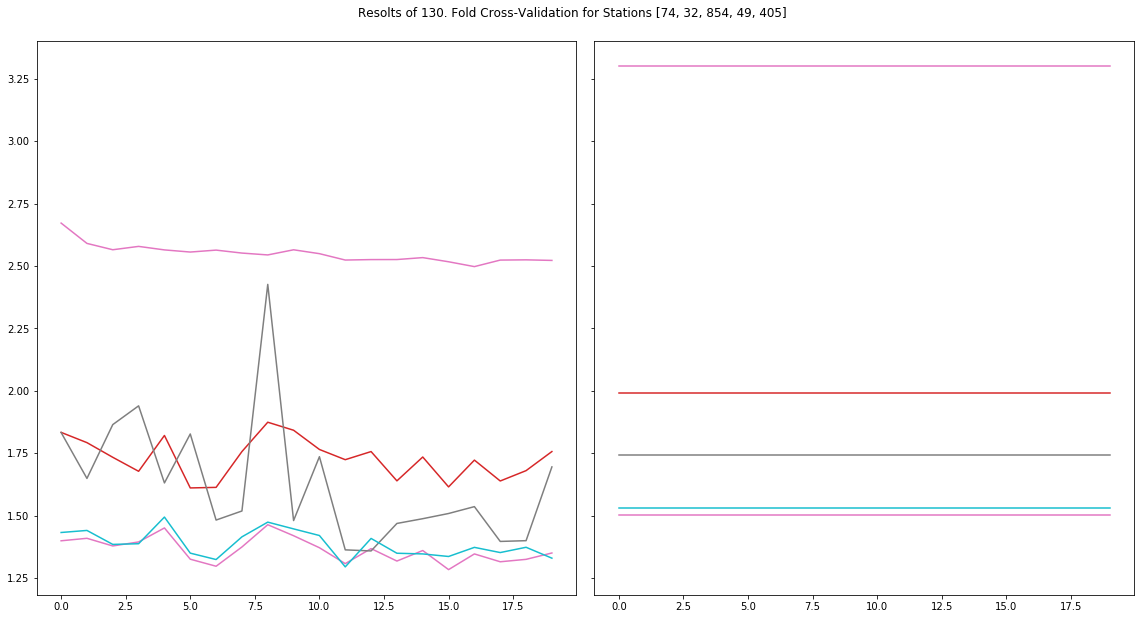

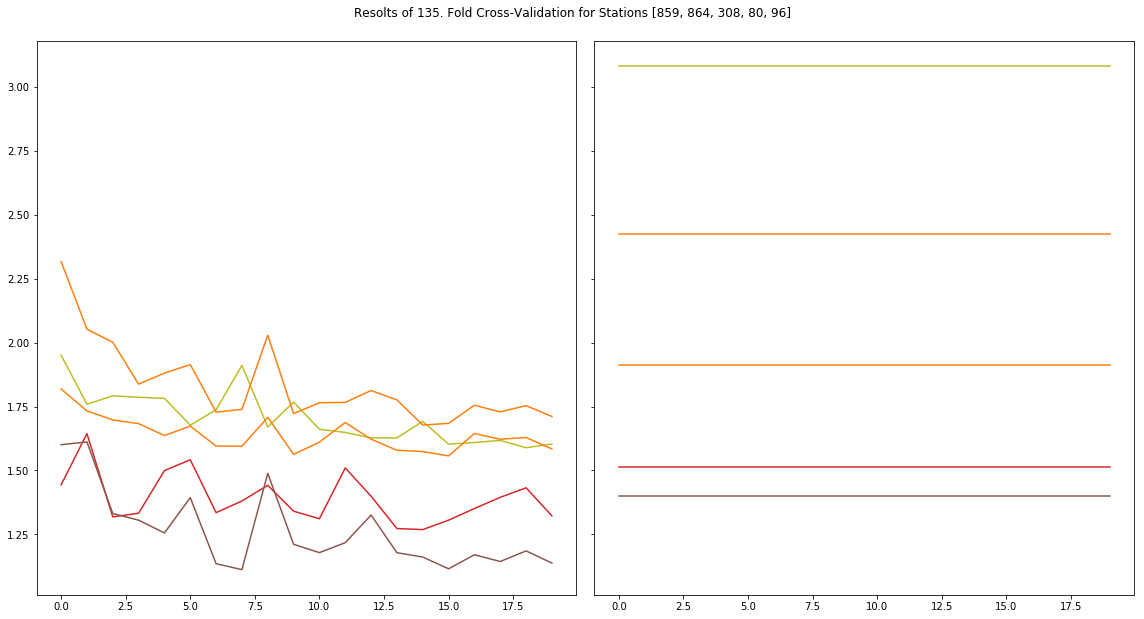

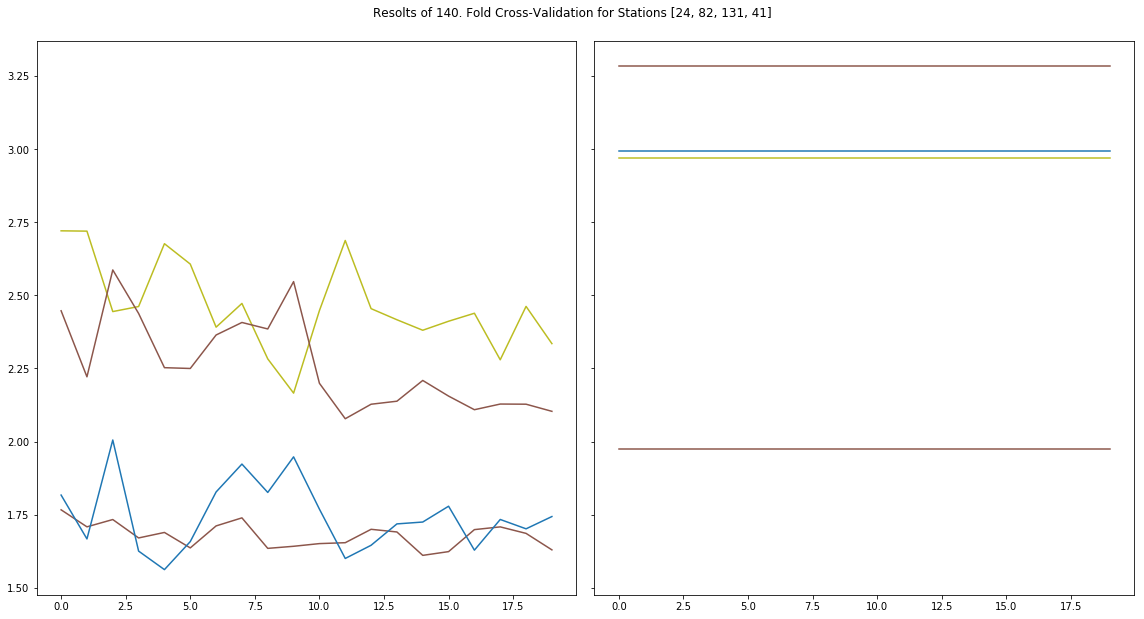

In [8]:
experiment_order_station_ids = []
for first_station in np.arange(0,141,5):
    ds = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/spatial_generalization_experiment/spatial_generalization_with_dropout/experiment/first_station_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/rmse_per_station.pkl' % first_station,'rb'))
    experiment_statistic = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/spatial_generalization_experiment/spatial_generalization_with_dropout/experiment/first_station_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/experiment_statistic.pkl' % first_station,'rb'))
    
    experiment_order_station_ids += list(experiment_statistic.attrs['test_stations'])
    
    # only keep entries for existing stations
    reduced_ds = ds.sel(run = 0, station = stations)
    
    # plot results for station fold not used in training
    fig, axes = plt.subplots(1,2, figsize=(16,9), sharex=True, sharey=True)
    axes[0].plot(reduced_ds.data[:,:,0])
    axes[1].plot(reduced_ds.data[:,:,1])
    fig.suptitle('Results of %s. Fold Cross-Validation for Stations %s' % (first_station, list(experiment_statistic.attrs['test_stations'])))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()

    try:
        all_data_dropout = xr.merge([all_data_dropout, reduced_ds.to_dataset(name='per_station_error')], compat='no_conflicts')
    except:
        print('Error')
        all_data_dropout = reduced_ds.to_dataset(name='per_station_error')

In [9]:
# calculate mean rmse per epoch and what epoch was the best for each station fold
mean_rmse_per_epoch = np.mean(all_data_dropout.per_station_error, axis=1)
best_epoch = np.argmin(mean_rmse_per_epoch[:,0]).item()

In [10]:
all_data_dropout.per_station_error[best_epoch,np.argmax(all_data_dropout.per_station_error[best_epoch,:,0]).item()].data

array([3.66690094, 4.27715383])

In [22]:
# Calculate maximum increase and decrease from epoc 1 to epoch 20
max_model_error_increase_per_station = np.max(all_data_dropout.per_station_error[-1,:,0] - all_data_dropout.per_station_error[0,:,0])
max_model_error_decrease_per_station = np.min(all_data_dropout.per_station_error[-1,:,0] - all_data_dropout.per_station_error[0,:,0])
print("Maximum decrease of model error per station: %.2f" % max_model_error_decrease_per_station)
print("Maximum increase of station error: %.2f" % max_model_error_increase_per_station)

Maximum decrease of model error per station: -0.75
Maximum increase of station error: 0.68


Max. Increase: -1.4925469313913837, Max. Decrease: 1.494753251061379


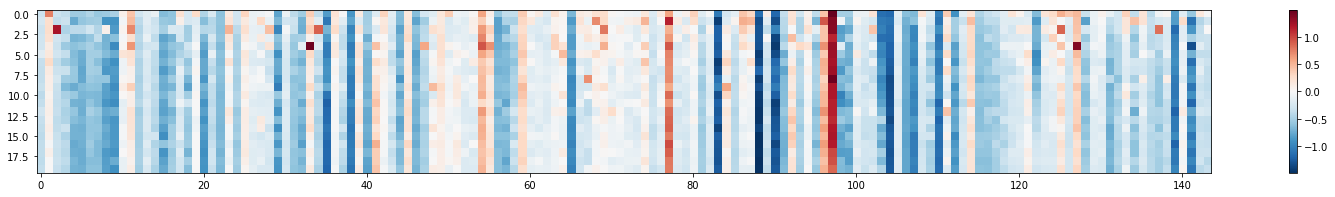

In [11]:
# plot evolution of RMSE over the epochs with dropout for each station, when not used in training
plt.figure(figsize=(28,3))
max_decrease = np.max(all_data_dropout.per_station_error[:,:,0] - all_data_dropout.per_station_error[:,:,1]).item()
max_increase = np.min(all_data_dropout.per_station_error[:,:,0] - all_data_dropout.per_station_error[:,:,1]).item()
print("Max. Increase: %s, Max. Decrease: %s" % (max_increase, max_decrease))
max_absolute_change = np.maximum(np.absolute(max_decrease), np.absolute(max_increase))
plt.imshow(all_data_dropout.per_station_error[:,:,0] - all_data_dropout.per_station_error[:,:,1], cmap='RdBu_r',
           vmin=-max_absolute_change, vmax=max_absolute_change)
plt.colorbar()
plt.show()

### Plot results of cross-validation experiment with dropout applied

Epoch: 0, Model RMSE: 1.994, COSMO RMSE: 2.134, FS: 6.59%, Worst 0 Stations: [], Worst 1 Station: 111
Epoch: 1, Model RMSE: 1.927, COSMO RMSE: 2.134, FS: 9.73%, Worst 0 Stations: [], Worst 1 Station: 111
Epoch: 2, Model RMSE: 1.965, COSMO RMSE: 2.134, FS: 7.92%, Worst 0 Stations: [], Worst 1 Station: 23
Epoch: 3, Model RMSE: 1.873, COSMO RMSE: 2.134, FS: 12.23%, Worst 0 Stations: [], Worst 1 Station: 111
Epoch: 4, Model RMSE: 1.915, COSMO RMSE: 2.134, FS: 10.25%, Worst 0 Stations: [], Worst 1 Station: 23
Epoch: 5, Model RMSE: 1.866, COSMO RMSE: 2.134, FS: 12.57%, Worst 0 Stations: [], Worst 1 Station: 111
Epoch: 6, Model RMSE: 1.838, COSMO RMSE: 2.134, FS: 13.89%, Worst 0 Stations: [], Worst 1 Station: 23
Epoch: 7, Model RMSE: 1.830, COSMO RMSE: 2.134, FS: 14.26%, Worst 0 Stations: [], Worst 1 Station: 111
Epoch: 8, Model RMSE: 1.834, COSMO RMSE: 2.134, FS: 14.06%, Worst 0 Stations: [], Worst 1 Station: 111
Epoch: 9, Model RMSE: 1.845, COSMO RMSE: 2.134, FS: 13.53%, Worst 0 Stations: [

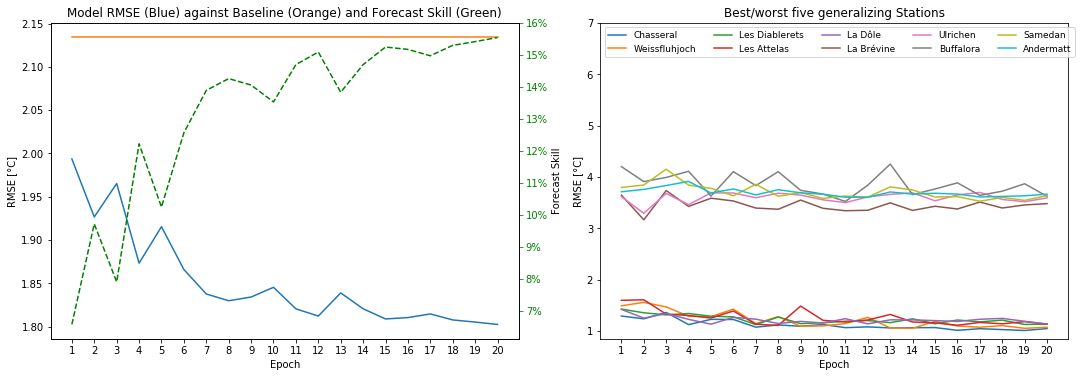

In [12]:
n_stations = 144
n_stations_taken = 144
best_forecast_skill = (0, 0)
per_epoch_rmse_data = np.zeros((20,3))
epoch_station_error = all_data_dropout.per_station_error
for epoch, station_error in enumerate(epoch_station_error):
    station_error = station_error.data
    sorted_stations = list(np.argsort(station_error[:,0]))
    best_stations = sorted_stations[:n_stations_taken]
    worst_stations = sorted_stations[n_stations_taken:]
    
    mean_rmse_model = np.mean(station_error[best_stations,0])
    mean_rmse_cosmo = np.mean(station_error[best_stations,1])
    
    forecast_skill = (1-(mean_rmse_model/mean_rmse_cosmo))*100
    
    if forecast_skill > best_forecast_skill[1]:
        best_forecast_skill = (epoch, forecast_skill)
    print('Epoch: %s, Model RMSE: %.3f, COSMO RMSE: %.3f, FS: %.2f%%, Worst %s Stations: %s, Worst 1 Station: %s' % (epoch,
                                                                                mean_rmse_model,
                                                                                mean_rmse_cosmo,
                                                                                forecast_skill,
                                                                                n_stations-n_stations_taken,
                                                                                worst_stations,
                                                                                sorted_stations[-1]))
    per_epoch_rmse_data[epoch] = np.array((mean_rmse_model, mean_rmse_cosmo, forecast_skill))
    
print('Best Epoch: %s, Forecast Skill (FS): %.2f%%' % best_forecast_skill)

fig, ax = plt.subplots(1,2, figsize=(16,6), sharex=True)
ax[0].plot(per_epoch_rmse_data[:,:2])
ax[0].set_ylabel('RMSE [°C]')
ax[0].set_xlabel('Epoch')
ax[0].set_xticks(range(0,20))
ax[0].set_xticklabels(range(1,21))

ax2 = ax[0].twinx()
ax2.plot(per_epoch_rmse_data[:,2], 'g--')
ax2.set_ylabel('Forecast Skill')
ax2.set_yticks(np.arange(7,17))
ax2.set_yticklabels(['%i%%' % fs for fs in np.arange(7,17)])
ax2.tick_params('y', colors='g')

ax[0].set_title('Model RMSE (Blue) against Baseline (Orange) and Forecast Skill (Green)')


# print test error by epoch for best and worst 5 stations after 20 epochs

# get idx of stations in experiment ordering of stations
best_5_stations_epoch_20 = sorted_stations[:5]
worst_5_stations_epoch_20 = sorted_stations[-5:]

ax[1].plot(epoch_station_error[:, best_5_stations_epoch_20 + worst_5_stations_epoch_20, 0])
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('RMSE [°C]')
ax[1].set_ylim(top=7)
ax[1].legend([station_names[s].item() for s in best_5_stations_epoch_20 + worst_5_stations_epoch_20], loc="upper left", ncol=5, fontsize=9)
ax[1].set_title('Best/worst five generalizing Stations')
fig.tight_layout(rect=[0, 0.03, 1, 0.92])
plt.show()

# Backup (Not working)

[843  44  61  70  23]


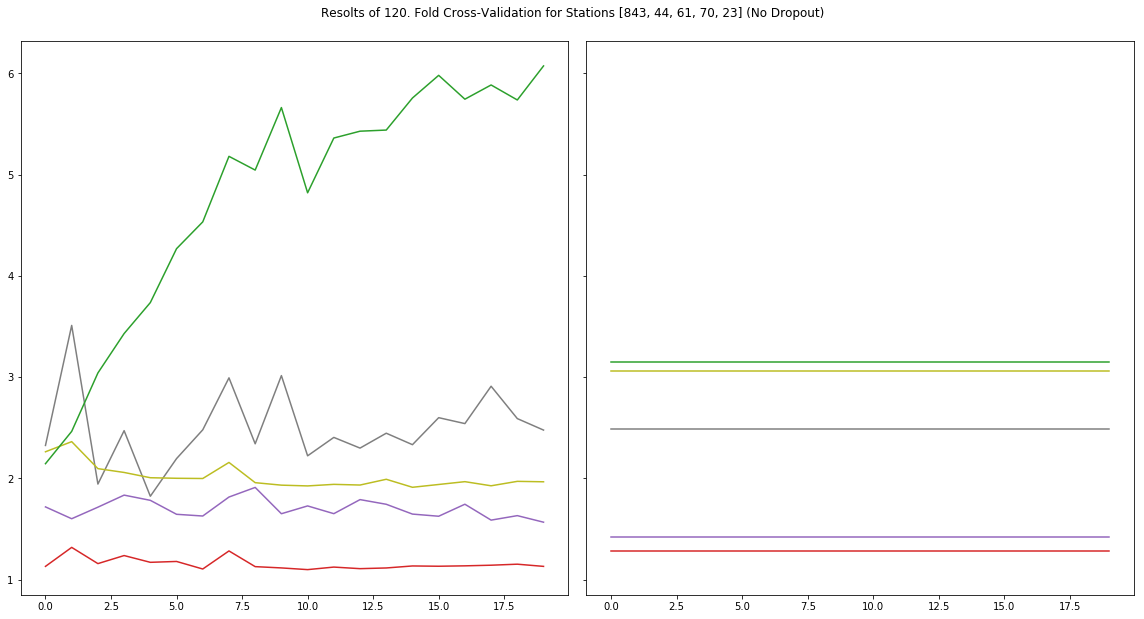

FileNotFoundError: [Errno 2] No such file or directory: '/home/ninow/master_thesis/code/project/results/runs/first_station_95_dropout/dropout_0_5/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/rmse_per_station.pkl'

In [7]:
ds = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/spatial_generalization_experiment/experiment/first_station_95/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/rmse_per_station.pkl','rb'))
experiment_statistic = pkl.load(open('/mnt/ds3lab-scratch/ninow/final_results/network/spatial_generalization_experiment/experiment/first_station_95/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/experiment_statistic.pkl','rb'))

print(experiment_statistic.attrs['test_stations'])

# only keep entries for existing stations
reduced_ds = ds.sel(run = 0, station = stations)


fig, axes = plt.subplots(1,2, figsize=(16,9), sharex=True, sharey=True)
axes[0].plot(reduced_ds.data[:,:,0])
axes[1].plot(reduced_ds.data[:,:,1])
fig.suptitle('Resolts of %s. Fold Cross-Validation for Stations %s (No Dropout)' % (120, list(experiment_statistic.attrs['test_stations'])))
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.close()

for drop_out in ['0_1', '0_25', '0_5']:
    if drop_out in ['0_1', '0_25']:
        continue
    ds = pkl.load(open('/home/ninow/master_thesis/code/project/results/runs/first_station_95_dropout/dropout_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/rmse_per_station.pkl' % drop_out,'rb'))
    experiment_statistic = pkl.load(open('/home/ninow/master_thesis/code/project/results/runs/first_station_95_dropout/dropout_%s/FC_L3_1024_256_64_TD_GTI_STI_grid_1_bs_64_tf_0.1_optim_sgd_lr_0.0005_sl_21/experiment_statistic.pkl' % drop_out,'rb'))
    
    print(experiment_statistic.attrs['test_stations'])
    
    # only keep entries for existing stations
    reduced_ds = ds.sel(run = 0, station = stations)
    
    
    fig, axes = plt.subplots(1,2, figsize=(16,9), sharex=True, sharey=True)
    axes[0].plot(reduced_ds.data[:,:,0])
    axes[1].plot(reduced_ds.data[:,:,1])
    fig.suptitle('Resolts of %s. Fold Cross-Validation for Stations %s (Dropout: %s)' % (first_station, list(experiment_statistic.attrs['test_stations']), drop_out))
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    plt.close()